# EDA

In [160]:
!pip install meteostat
!pip install statsmodels
!pip install plotly
!pip install missingno

In [161]:
import pandas as pd
import numpy as np

import datetime

from meteostat import Point, Daily
import sqlalchemy as sa

from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

import plotly.express as px
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

******

************

## 1. Consulta a la base de datos

In [162]:
import pymysql
import pandas as pd

class DatabaseConnection:
    def __init__(self, password, username="",
                 host="",
                 port=3306,
                 database="data"):
        self.host = host
        self.port = port
        self.username = username
        self.password = password
        self.database = database

    # Usamos una función para ejecutar una query y recibir un DataFrame de Pandas
    def query_to_df(self, query):
        # Establecemos la conexión usando pymysql
        connection = pymysql.connect(
            host=self.host,
            user=self.username,
            password=self.password,
            db=self.database,
            port=self.port
        )
        # Ejecutamos la query y metemos los datos en un DataFrame
        try:
            df = pd.read_sql(query, connection)
        finally:
            connection.close()
        return df


In [163]:
# Query para obtener todas las tablas y meterlas en la database que estamos usando
query_show_tables = "SHOW TABLES"
database = DatabaseConnection("")

# Obtenemos la lista de tablas e imprimirlas
tables = database.query_to_df(query_show_tables)
print("Tables in the database:")
print(tables)


Tables in the database:
           Tables_in_data
0  ventas_diarias_estudio


/tmp/ipykernel_5764/321962845.py:27: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



In [164]:
# Definimos la query
query_daily_and_top = """
SELECT familia,
articulo,
fechaVenta AS fecha_venta,
festivo,
precio,
cantidad,
importe,
orden_articulo_familia
FROM ventas_diarias_estudio
"""

# Ejemplificamos la clase con la contraseña
database = DatabaseConnection("") 

# Ejecutamos la query y metemos los resultados en un DataFrame
ventas = database.query_to_df(query_daily_and_top)

# Convertimos 'fecha_venta' a formato de fecha y 'articulo' a integer
ventas = ventas.assign(
    fecha_venta=pd.to_datetime(ventas["fecha_venta"])
).astype({"articulo": int})

# Imprimimos los resultados
print(ventas.head())

/tmp/ipykernel_5764/321962845.py:27: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



    familia  articulo fecha_venta festivo  precio  cantidad     importe  \
0  BOLLERIA      3960  2021-05-18    None   2.318     216.0  500.688008   
1  BOLLERIA      6286  2021-08-29    None   3.136      99.0  310.464005   
2  BOLLERIA      3880  2021-09-21    None   3.000     102.0  306.000000   
3  BOLLERIA      5803  2021-10-21    None   3.000      42.0  126.000000   
4  BOLLERIA      3880  2021-12-07    None   3.000     141.0  423.000000   

   orden_articulo_familia  
0                       1  
1                       4  
2                       3  
3                       5  
4                       3  


In [165]:
ventas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10574 entries, 0 to 10573
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   familia                 10574 non-null  object        
 1   articulo                10574 non-null  int64         
 2   fecha_venta             10574 non-null  datetime64[ns]
 3   festivo                 837 non-null    object        
 4   precio                  10574 non-null  float64       
 5   cantidad                10574 non-null  float64       
 6   importe                 10574 non-null  float64       
 7   orden_articulo_familia  10574 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(2), object(2)
memory usage: 661.0+ KB


In [166]:
ventas.head()

,familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia
0,BOLLERIA,3960,2021-05-18,None,2.318,216.0,500.688008,1
1,BOLLERIA,6286,2021-08-29,None,3.136,99.0,310.464005,4
2,BOLLERIA,3880,2021-09-21,None,3.000,102.0,306.000000,3
3,BOLLERIA,5803,2021-10-21,None,3.000,42.0,126.000000,5
4,BOLLERIA,3880,2021-12-07,None,3.000,141.0,423.000000,3


In [167]:
ventas['festivo'].unique()

array([None, 'Feria de Málaga', 'Noche de Halloween', 'Nochevieja',
       'Martes Santo', 'Día de la Hispanidad (Fiesta Nacional de España)',
       'Jueves Santo', 'Día de Todos los Santos', 'Navidad',
       'Día de la Madre', 'Lunes Santo', 'Día de la Constitución',
       'Día del Padre', 'Día de Reyes', 'Domingo de Ramos',
       'Viernes Santo', 'Día de San Valentín', 'Día de la Cruz',
       'Domingo de Resurrección', 'Día de la Virgen del Carmen',
       'Día de San Juan', 'Nochebuena', 'Miércoles Santo', 'Sábado Santo',
       'Año Nuevo', 'Fiesta de la Virgen de la Victoria',
       'Día de la Victoria'], dtype=object)

In [168]:
ventas.sample(10)

,familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia
2153,PANADERIA,968,2022-07-19,None,2.452000,213.00,522.275995,1
10137,PASTELERIA,6549,2021-08-24,None,28.500000,12.00,342.000000,5
8005,BOLLERIA,5803,2021-12-26,None,3.000000,123.00,369.000000,5
159,PASTELERIA,6523,2023-03-08,None,40.772999,6.00,244.638000,3
5691,BOLLERIA,5803,2023-01-13,None,3.545000,66.00,233.970005,5
2764,BOLLERIA,5803,2021-10-05,None,3.000000,54.00,162.000000,5
9607,PASTELERIA,5404,2021-07-02,None,39.544998,26.25,1038.056000,1
688,BOLLERIA,6286,2021-11-21,None,3.409000,264.00,899.976005,4
2549,PASTELERIA,6549,2023-05-01,None,32.591000,6.00,195.546005,5
8744,PANADERIA,1084,2021-06-21,None,0.865000,549.00,474.885004,4


******

***************

## 2. Consulta a [meteostat API](https://dev.meteostat.net/python/daily.html)

Variables que se obtienen:

- **tavg** -> The average air temperature in °C
- **tmin** -> The minimum air temperature in °C
- **tmax** -> The maximum air temperature in °C
- **prcp** -> The daily precipitation total in mm
- **wdir** -> The average wind direction in degrees (°)
- **wspd** -> The average wind speed in km/h
- **pres** -> The average sea-level air pressure in hPa

In [169]:
import requests
from requests.packages.urllib3.exceptions import InsecureRequestWarning
class DailyWeatherData:

    # Localización de la panadería. Metemos la latitud y la longitud de la tienda.
    ECHEVERRIA_SHOP = Point(, -4)

    # Columnas identificadas como importantes. Son las que meteremos en el dataframe.
    IMP_COLUMNS = ['tavg', 'tmin', 'tmax', 'prcp', 'wdir', 'wspd', 'pres']

    # Definición del horizonte temporal de la consulta a la API
    def __init__(self, start, end = datetime.datetime.now()):
        self.start = start
        self.end = end

    # Se establece que la consulta será diaria, se seleccionan todas las columnas imps y se añade un suff.
    def get_weather_data(self):
        requests.packages.urllib3.disable_warnings(InsecureRequestWarning)
        daily_data = Daily(self.ECHEVERRIA_SHOP, self.start, self.end)
        data = daily_data.fetch()
        return data[self.IMP_COLUMNS].add_suffix('_w').reset_index()

In [170]:
# Fecha en la que comienza el conjunto de datos de ventas
# Se puede definir también en este formato -> Ej: datetime.datetime(2017, 1, 1)
start = ventas["fecha_venta"].min()

# Fecha en la que termina el conjunto de datos de ventas
# Se puede definir también en este formato -> Ej: datetime.datetime(2017, 1, 1)
end = ventas["fecha_venta"].max()

# Instancia la clase con el horizonte temporal a consultar. Le decimos la fecha de estrada y la fecha de salida.
weather_query = DailyWeatherData(start, end)

# Obtenemos la info del tiempo del horizonte temporal consultado
weather = weather_query.get_weather_data()

# Nos devuelve un dataframe con los datos que le hemos pedido. Lo usaremos para hacer los análisis de si la lluvia es relevante, por ejemplo.
weather.head()

,time,tavg_w,tmin_w,tmax_w,prcp_w,wdir_w,wspd_w,pres_w
0,2021-05-01,17.2,11.9,22.8,0.0,282.0,14.2,1014.0
1,2021-05-02,16.3,10.8,23.2,0.0,233.0,15.7,1015.9
2,2021-05-03,15.3,12.7,20.1,6.5,272.0,9.7,1017.7
3,2021-05-04,16.5,12.0,20.9,0.0,206.0,12.1,1018.0
4,2021-05-05,16.7,12.3,21.7,0.0,132.0,13.8,1016.5


In [171]:
# ¿Hay nulls en los datos?
weather.isnull().sum()

time      0
tavg_w    0
tmin_w    0
tmax_w    0
prcp_w    0
wdir_w    0
wspd_w    0
pres_w    0
dtype: int64

In [172]:
weather.describe()

,tavg_w,tmin_w,tmax_w,prcp_w,wdir_w,wspd_w,pres_w
count,748.000000,748.000000,748.000000,748.000000,748.000000,748.000000,748.000000
mean,19.368316,15.202674,24.881150,0.802005,214.990642,14.301471,1018.020187
std,5.344832,5.509558,5.924562,4.336827,74.284349,5.286517,5.126006
min,7.300000,1.100000,13.300000,0.000000,10.000000,6.000000,1004.400000
25%,14.600000,10.900000,19.700000,0.000000,142.000000,10.900000,1014.500000
50%,19.350000,14.700000,24.700000,0.000000,241.500000,12.500000,1017.250000
75%,23.800000,19.900000,29.600000,0.000000,284.000000,16.800000,1021.000000
max,33.500000,27.500000,42.600000,46.800000,356.000000,46.500000,1032.800000


In [173]:
weather.to_excel("20240319 variables meteorologicas.xlsx", "Data", index = False)

******

*********************

## 3. Join -> Datos de ventas y del tiempo

In [174]:
# Join del conjunto de datos de ventas y del tiempo por medio de la columna de fecha
df = pd.merge(ventas, weather,
              left_on=["fecha_venta"], right_on=["time"],
              how="inner").drop("time", axis=1)

# Ordenamos el dataframe
df.sort_values(["fecha_venta", "articulo"], inplace = True)

df.head(5)

,familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia,tavg_w,tmin_w,tmax_w,prcp_w,wdir_w,wspd_w,pres_w
8952,PANADERIA,417,2021-05-01,None,4.038,72.0,290.736004,5,17.2,11.9,22.8,0.0,282.0,14.2,1014.0
8950,PANADERIA,900,2021-05-01,None,0.865,651.0,563.114998,3,17.2,11.9,22.8,0.0,282.0,14.2,1014.0
8945,PANADERIA,968,2021-05-01,None,2.163,450.0,973.350002,1,17.2,11.9,22.8,0.0,282.0,14.2,1014.0
8948,PANADERIA,1043,2021-05-01,None,2.596,327.0,848.892002,2,17.2,11.9,22.8,0.0,282.0,14.2,1014.0
8955,PANADERIA,1084,2021-05-01,None,0.865,423.0,365.895005,4,17.2,11.9,22.8,0.0,282.0,14.2,1014.0


******

******

## 4. EDA

******

#### 4.1. Inspección inicial

Este apartado tiene como cometido comprender la estructura del conjunto de datos y ver posibles problemas de calidad que podrían afectar al análisis.

**Grupo de preguntas 1**:

**¿Qué significa cada fila del dataframe?**

Cada fila representa la agrupación por día de cada producto.

In [175]:
# Usamos el método sample para ver algunas filas de forma aleatoria.
df.sample(5)

,familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia,tavg_w,tmin_w,tmax_w,prcp_w,wdir_w,wspd_w,pres_w
8025,PASTELERIA,6523,2022-05-17,None,39.544998,3.0,118.635002,3,20.9,16.0,26.2,0.0,128.0,12.6,1018.5
5266,PASTELERIA,6523,2021-06-21,None,32.591000,3.0,97.773003,3,25.1,20.9,31.0,0.0,259.0,18.3,1012.7
5088,BOLLERIA,6286,2021-11-21,None,3.409000,264.0,899.976005,4,14.7,11.3,20.8,2.2,283.0,10.1,1015.8
9083,BOLLERIA,5803,2022-06-28,None,3.545000,39.0,138.255003,5,22.2,18.4,27.4,0.0,129.0,13.5,1017.2
578,PASTELERIA,5403,2022-02-22,None,36.818001,6.3,231.953003,2,13.6,7.3,20.7,0.0,221.0,12.6,1026.5


In [176]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10574 entries, 8952 to 10189
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   familia                 10574 non-null  object        
 1   articulo                10574 non-null  int64         
 2   fecha_venta             10574 non-null  datetime64[ns]
 3   festivo                 837 non-null    object        
 4   precio                  10574 non-null  float64       
 5   cantidad                10574 non-null  float64       
 6   importe                 10574 non-null  float64       
 7   orden_articulo_familia  10574 non-null  int64         
 8   tavg_w                  10574 non-null  float64       
 9   tmin_w                  10574 non-null  float64       
 10  tmax_w                  10574 non-null  float64       
 11  prcp_w                  10574 non-null  float64       
 12  wdir_w                  10574 non-null  flo

In [177]:
# Analizamos las variables numéricas. En este caso es interesante ver que el dataframe va desde el 1 de mayo de 2021 hasta el 18 de mayo de 2023.
df.describe()

,articulo,precio,cantidad,importe,orden_articulo_familia,tavg_w,tmin_w,tmax_w,prcp_w,wdir_w,wspd_w,pres_w
count,10574.000000,10574.000000,10574.000000,10574.000000,10574.000000,10574.000000,10574.000000,10574.000000,10574.000000,10574.000000,10574.000000,10574.000000
mean,3945.091734,15.414053,137.687953,462.520794,2.961982,19.391290,15.222035,24.909504,0.780433,214.954416,14.324012,1018.017524
std,2404.630373,17.003998,148.164571,274.155030,1.395454,5.349137,5.506365,5.931939,4.260470,74.274628,5.315511,5.112373
min,417.000000,0.865000,1.200000,9.000000,1.000000,7.300000,1.100000,13.300000,0.000000,10.000000,6.000000,1004.400000
25%,1043.000000,2.591000,15.000000,287.887500,2.000000,14.600000,10.900000,19.700000,0.000000,142.000000,10.900000,1014.500000
50%,5403.000000,3.545000,84.000000,405.000000,3.000000,19.400000,14.700000,24.700000,0.000000,242.000000,12.500000,1017.200000
75%,6286.000000,34.091000,219.000000,569.655075,4.000000,23.800000,19.900000,29.600000,0.000000,284.000000,16.800000,1021.000000
max,6549.000000,43.500000,1110.000000,3271.929962,5.000000,33.500000,27.500000,42.600000,46.800000,356.000000,46.500000,1032.800000


In [178]:
# En este caso es interesante ver que tenemos 3 clases de familia y 26 clases dentro de la variable de "festivo"
df.describe(include='object')

,familia,festivo
count,10574,837
unique,3,26
top,PANADERIA,Feria de Málaga
freq,3740,99


**¿Cuántos valores únicos hay en cada una de las variables? ¿Qué insight podrías observar al comparar los valores únicos de la variable "articulo" con los valores únicos de la variable "precio"?** 

El precio del artículo varía dependiendo del día. 

In [179]:
# La diferencia entre el número único de artículos y de precios muestra que los precios cambian a lo largo del tiempo

# Cardinalidad: número de valores diferentes, únicos
# Granularidad: cuánta variedad tienen los datos en relación con el total de registros. Porcentaje de valores únicos.

# Creamos un dataframe con diferentes campos
(
  df.dtypes.to_frame("Tipo")
    .assign(Cardinalidad = df.nunique())
    .assign(Granularidad = df.nunique() / len(df) * 100)
    .assign(Nulos_Pct = df.isnull().sum() / len(df) * 100)
    .assign(Max = df.dropna().apply(max))
    .assign(Min = df.dropna().apply(min))
    .sort_values(["Tipo"])
)

,Tipo,Cardinalidad,Granularidad,Nulos_Pct,Max,Min
articulo,int64,15,0.141857,0.000000,6549,417
fecha_venta,datetime64[ns],748,7.073955,0.000000,2023-05-07 00:00:00,2021-05-02 00:00:00
orden_articulo_familia,int64,5,0.047286,0.000000,5,1
precio,float64,45,0.425572,0.000000,43.5,0.865
cantidad,float64,1418,13.410252,0.000000,966.0,2.88
importe,float64,6303,59.608474,0.000000,2377.851974,85.080002
tavg_w,float64,200,1.891432,0.000000,31.1,11.1
tmin_w,float64,214,2.023832,0.000000,26.3,5.2
tmax_w,float64,221,2.090032,0.000000,39.2,15.0
prcp_w,float64,59,0.557972,0.000000,24.1,0.0


**¿Hay nulos?**

En este caso, tenemos un 92.084358 de valores nulos para la variable de "festivos".

<Axes: >

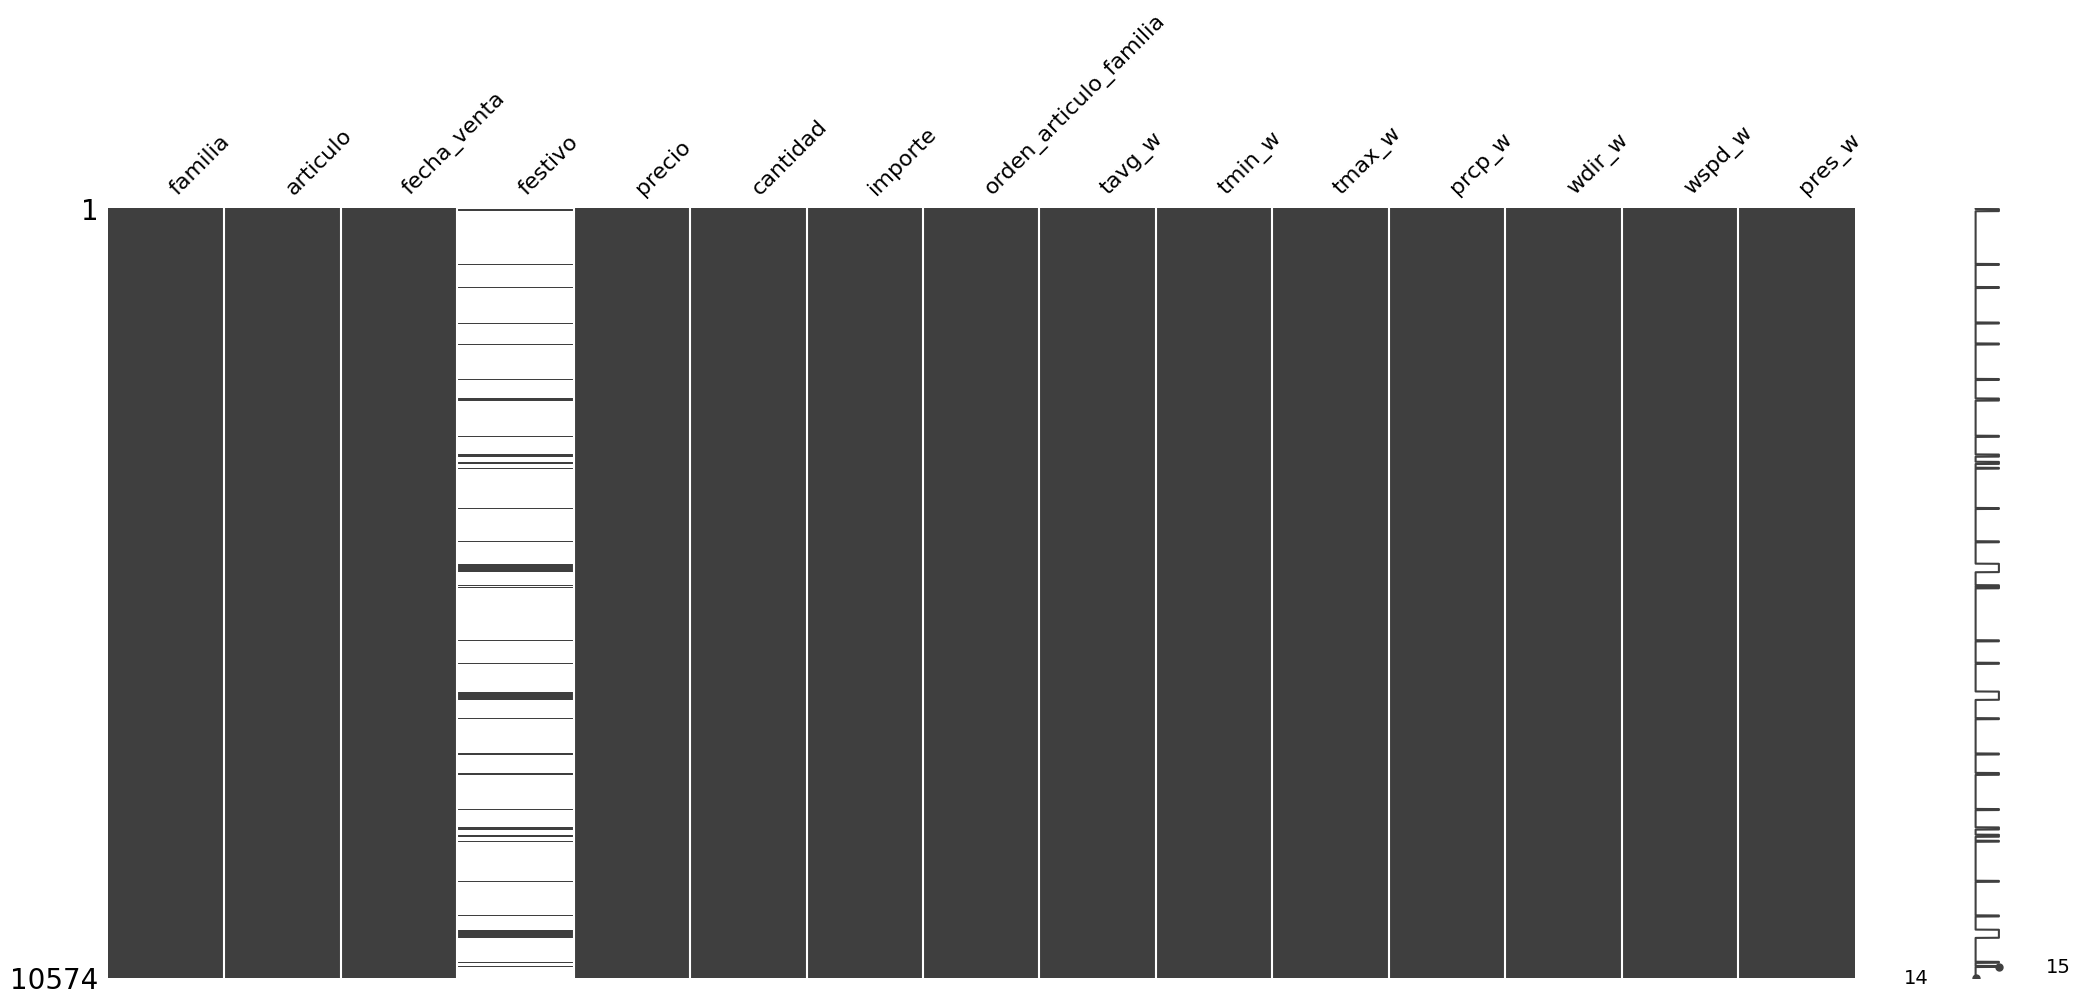

In [180]:
# Valores nulos

msno.matrix(df)

In [181]:
# Otra forma de ver los nulos (en porcentaje)
df.isnull().sum()/len(df) * 100

familia                    0.000000
articulo                   0.000000
fecha_venta                0.000000
festivo                   92.084358
precio                     0.000000
cantidad                   0.000000
importe                    0.000000
orden_articulo_familia     0.000000
tavg_w                     0.000000
tmin_w                     0.000000
tmax_w                     0.000000
prcp_w                     0.000000
wdir_w                     0.000000
wspd_w                     0.000000
pres_w                     0.000000
dtype: float64

**¿Hay valores duplicados?**

En este caso, no tenemos valores duplicados.

In [182]:
# Valores duplicados

df[df.duplicated(['fecha_venta', 'articulo'], keep=False)]
#df.drop_duplicates(['fecha_venta', 'articulo'])

,familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia,tavg_w,tmin_w,tmax_w,prcp_w,wdir_w,wspd_w,pres_w


In [183]:
num_duplicados = df.duplicated().sum()
print(f"Total de filas duplicadas: {num_duplicados}")

Total de filas duplicadas: 0


**Grupo de preguntas 2**:

**¿Cuál es el rango de fechas de nuestro conjunto de datos? Si se divide por producto, ¿hay fechas faltantes? Crea un gráfico de evolución temporal para la variable "cantidad" que muestre el producto "3960".**

In [184]:
# Rango de fechas del conjunto de datos

min_date = df['fecha_venta'].min()
max_date = df['fecha_venta'].max()

print(f"El conjunto de datos contiene valores desde {min_date} hasta {max_date}. ",
      f"Lo que supone {max_date - min_date}")

El conjunto de datos contiene valores desde 2021-05-01 00:00:00 hasta 2023-05-18 00:00:00.  Lo que supone 747 days 00:00:00


In [185]:
# Fechas faltantes

# Extraemos los ids únicos de los artículos
unique_articles = df.sort_values("familia")["articulo"].unique().tolist()

# Generamos una variable con el rango de fechas de nuestro estudio
complete_range = pd.date_range(start=min_date, end=max_date, freq='D')

for article in unique_articles:

    #Filtramos el df por el articulo en cuestión
    #subset = df.query("articulo == @article")
    subset = df[df['articulo'] == article]
    family = subset["familia"].unique().tolist()[0]

    # Vemos si hay alguna fecha de este subset que no esté en el rango completo de fechas (sería una fecha faltante)
    missing_dates = complete_range.difference(subset['fecha_venta'])

    print(family, "-> Articulo", article, "-> Fechas faltantes", len(missing_dates))

BOLLERIA -> Articulo 5803 -> Fechas faltantes 3
BOLLERIA -> Articulo 6286 -> Fechas faltantes 2
BOLLERIA -> Articulo 6425 -> Fechas faltantes 1
BOLLERIA -> Articulo 3960 -> Fechas faltantes 0
BOLLERIA -> Articulo 3880 -> Fechas faltantes 0
PANADERIA -> Articulo 1043 -> Fechas faltantes 0
PANADERIA -> Articulo 968 -> Fechas faltantes 0
PANADERIA -> Articulo 900 -> Fechas faltantes 0
PANADERIA -> Articulo 417 -> Fechas faltantes 0
PANADERIA -> Articulo 1084 -> Fechas faltantes 0
PASTELERIA -> Articulo 5404 -> Fechas faltantes 98
PASTELERIA -> Articulo 6523 -> Fechas faltantes 49
PASTELERIA -> Articulo 5403 -> Fechas faltantes 107
PASTELERIA -> Articulo 6451 -> Fechas faltantes 74
PASTELERIA -> Articulo 6549 -> Fechas faltantes 312


In [186]:
# Gráfico de la cantidad del producto número 3960

# Creamos una variable para filtrar el artículo 3960

articulo = 3960
filtered_df = df[df['articulo'] == articulo]

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": False}]])

# Add traces
fig.add_trace(
    go.Scatter(x=filtered_df["fecha_venta"], y=filtered_df["cantidad"], name="Cantidad vendida"),
    secondary_y=False,
)

# Set x-axis title
fig.update_xaxes(title_text="Fecha")

# Set y-axes titles
fig.update_yaxes(title_text="Cantidad", secondary_y=False)

fig.show()

# Como el gráfico es a nivel día, se ven muchos data points

Text(0, 0.5, 'Cantidad')

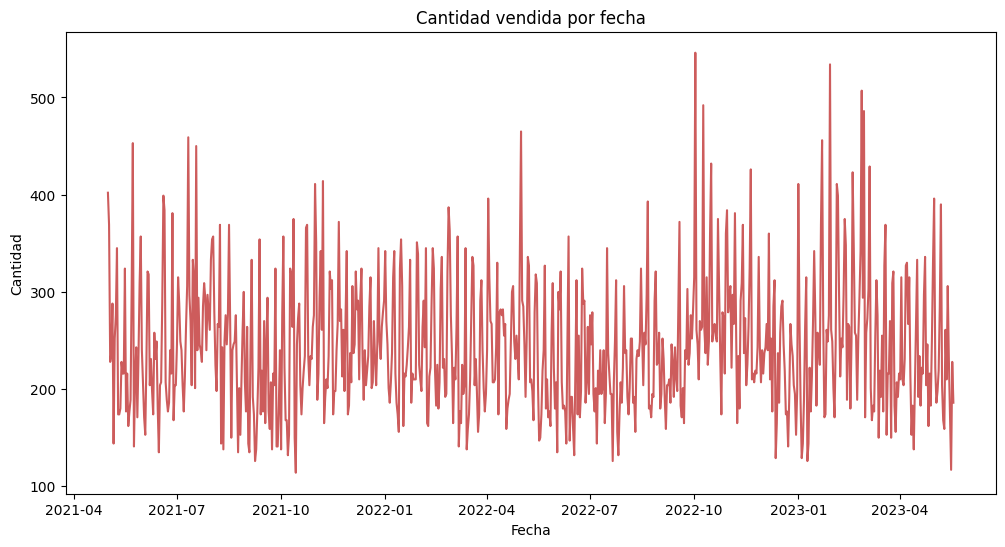

In [187]:
# Gráfico representando la cantidad vendida por fecha
# Rellenamos las fechas ausentes con el rango completo (complete_range)
# Usamos fillna para rellenar valores que faltan

articulo = 3960
filtered_df = (
    df.query("articulo == @articulo")
      .set_index("fecha_venta")
      .reindex(complete_range)
)

filtered_df["articulo"] = filtered_df["articulo"].fillna(method='ffill')
plt.figure(figsize=(12, 6))
sns.lineplot(data=filtered_df, x=filtered_df.index, y='cantidad', color='indianred')
plt.title('Cantidad vendida por fecha')
plt.xlabel('Fecha')
plt.ylabel('Cantidad')


**Separando por producto, ¿hay outliers en la variable "cantidad"?**

In [188]:
# Outliers en cantidad desglosando por producto y familia

unique_articles = df.sort_values("familia")["articulo"].unique().tolist()

for article in unique_articles:

    subset = df[df['articulo'] == articulo]
    family = subset['familia'].unique().tolist()[0]

    Q1 = subset['cantidad'].quantile(0.25)
    Q3 = subset['cantidad'].quantile(0.75)
    IQR = Q3 - Q1

    outliers = subset[(subset['cantidad'] < (Q1 - 1.5 * IQR)) | (subset['cantidad'] > (Q3 + 1.5 * IQR))]

    print(family, "-> Articulo", article, "-> Outliers", len(outliers["cantidad"]))

BOLLERIA -> Articulo 5803 -> Outliers 15
BOLLERIA -> Articulo 6286 -> Outliers 15
BOLLERIA -> Articulo 6425 -> Outliers 15
BOLLERIA -> Articulo 3960 -> Outliers 15
BOLLERIA -> Articulo 3880 -> Outliers 15
BOLLERIA -> Articulo 1043 -> Outliers 15
BOLLERIA -> Articulo 968 -> Outliers 15
BOLLERIA -> Articulo 900 -> Outliers 15
BOLLERIA -> Articulo 417 -> Outliers 15
BOLLERIA -> Articulo 1084 -> Outliers 15
BOLLERIA -> Articulo 5404 -> Outliers 15
BOLLERIA -> Articulo 6523 -> Outliers 15
BOLLERIA -> Articulo 5403 -> Outliers 15
BOLLERIA -> Articulo 6451 -> Outliers 15
BOLLERIA -> Articulo 6549 -> Outliers 15


Text(0.5, 0, 'Cantidad')

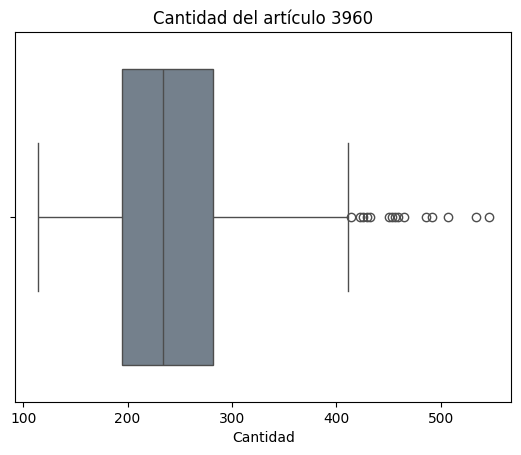

In [189]:
articulo_3960 = df[df['articulo'] == 3960]
sns.boxplot(data=articulo_3960, x='cantidad', color='slategrey')
plt.title('Cantidad del artículo 3960')
plt.xlabel('Cantidad')

*****

#### 4.2. Análisis de la variable a predecir

Este apartado tiene como cometido comprender la evolución de la variable "cantidad" en el tiempo y como se relaciona esta consigo misma.

**Grupo de preguntas 3**:

**Crea un gráfico de la evolución temporal general de la variable "cantidad". Nota: Se debe agrupar**

Text(0, 0.5, 'Cantidad')

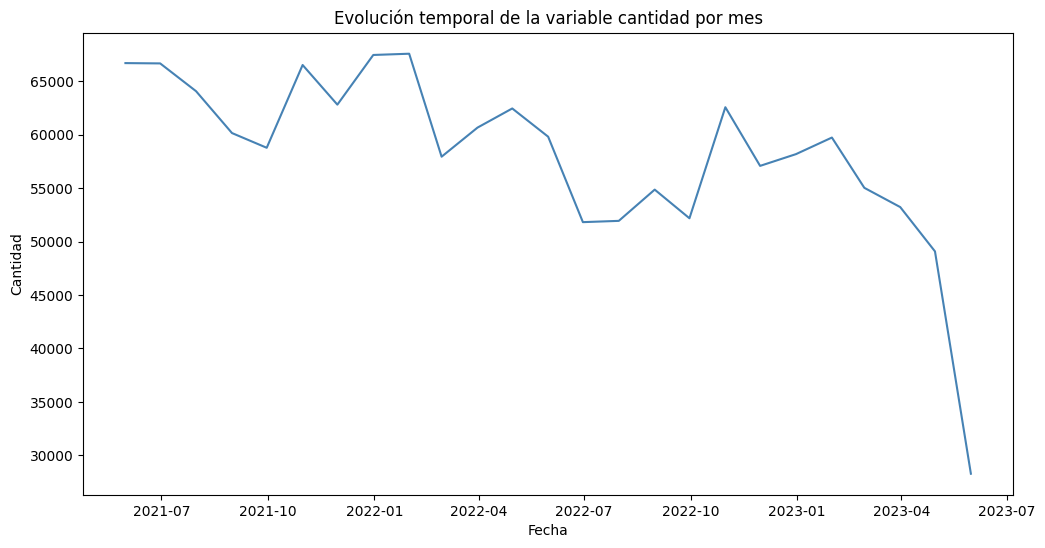

In [190]:
# En "freq" se puede especificar a nivel dia, mes, año...
group = df.groupby(pd.Grouper(key="fecha_venta", freq="M"))["cantidad"].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=group, x='fecha_venta', y='cantidad', color='steelblue')

plt.title('Evolución temporal de la variable cantidad por mes')
plt.xlabel('Fecha')
plt.ylabel('Cantidad')

Text(0, 0.5, 'Cantidad')

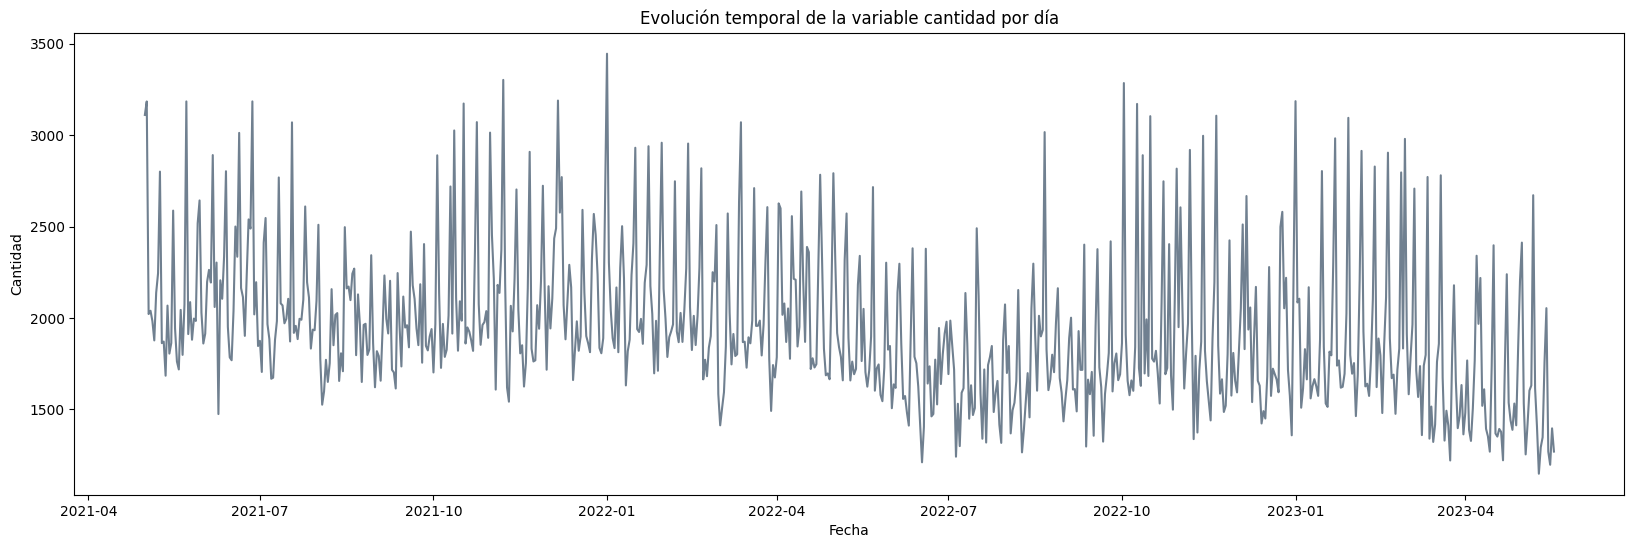

In [191]:
group = df.groupby(pd.Grouper(key="fecha_venta", freq="D"))["cantidad"].sum().reset_index()


plt.figure(figsize=(20, 6))
sns.lineplot(data=group, x='fecha_venta', y='cantidad', color='slategrey')

plt.title('Evolución temporal de la variable cantidad por día')
plt.xlabel('Fecha')
plt.ylabel('Cantidad')

**Crea un gráfico de la evolución temporal por familia de la variable "cantidad". Nota: Se debe agrupar.**

Text(0, 0.5, 'Cantidad')

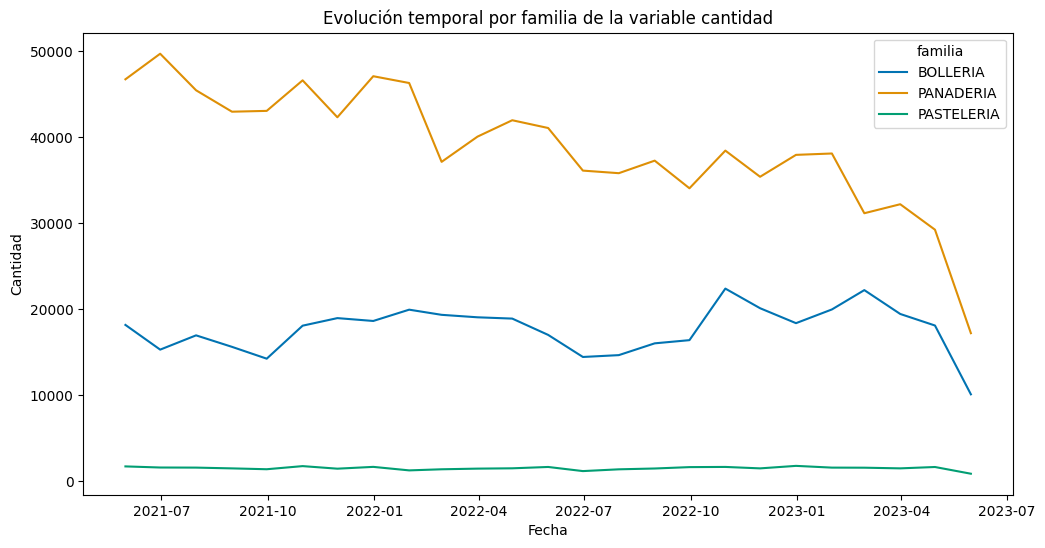

In [192]:
# Evolución temporal por familia de la variable "cantidad"
plt.figure(figsize=(12, 6))

group = df.groupby(["familia", pd.Grouper(key="fecha_venta", freq="M")])["cantidad"].sum().reset_index()
sns.lineplot(data=group, x='fecha_venta', y='cantidad', palette='colorblind', hue='familia')

plt.title('Evolución temporal por familia de la variable cantidad')
plt.xlabel('Fecha')
plt.ylabel('Cantidad')

**Crea un gráfico de la evolución temporal por artículo de la variable "cantidad". Nota: Se debe agrupar.**

Text(0, 0.5, 'Cantidad')

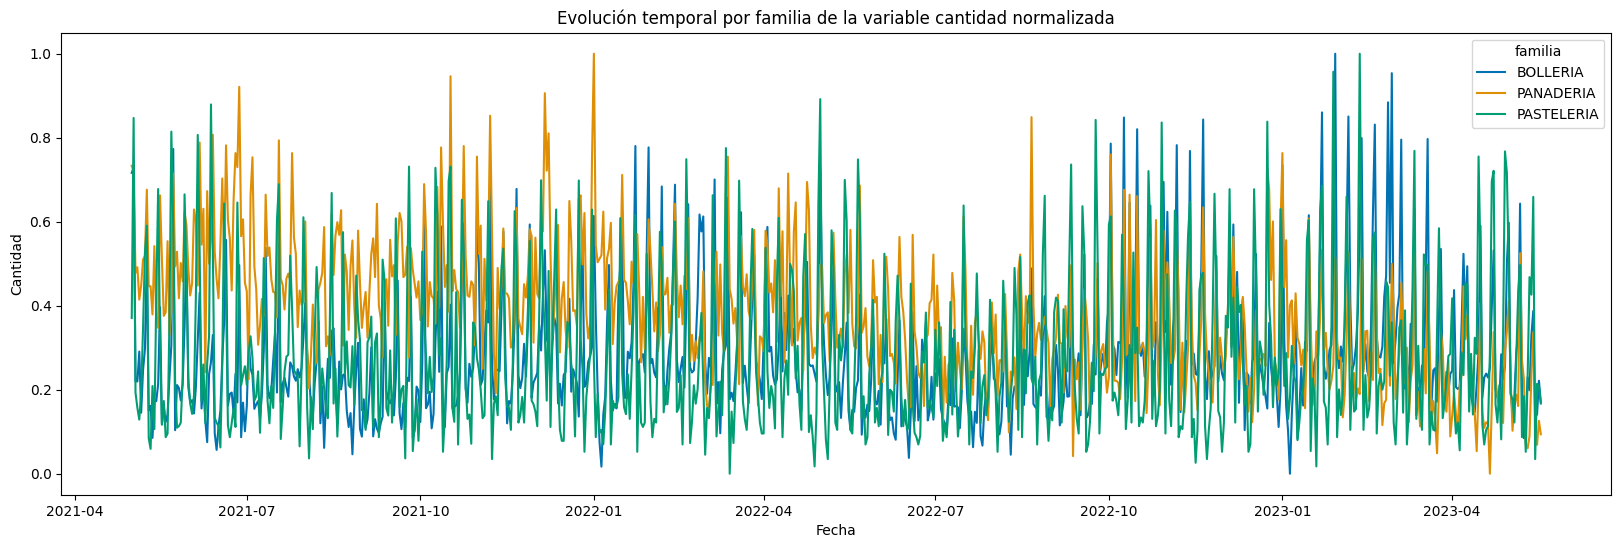

In [193]:
# Evolución temporal por familia de la variable "cantidad", normalizada para poder comparar

scaler = MinMaxScaler()

def normalize(column):
    return scaler.fit_transform(column.values.reshape(-1, 1)).flatten()

group = df.groupby(["familia", pd.Grouper(key="fecha_venta", freq="1D")])["cantidad"].sum().reset_index()
group['cantidad'] = group.groupby('familia')['cantidad'].transform(normalize)
plt.figure(figsize=(20, 6))
sns.lineplot(data=group, x='fecha_venta', y='cantidad', hue='familia', palette='colorblind')

plt.title('Evolución temporal por familia de la variable cantidad normalizada')
plt.xlabel('Fecha')
plt.ylabel('Cantidad')

**Sé que hay mucho ruido, pero ¿a simple vista crees que hay tendencia y/o estacionalidad en las series temporales anteriores?**

Text(0, 0.5, 'Cantidad')

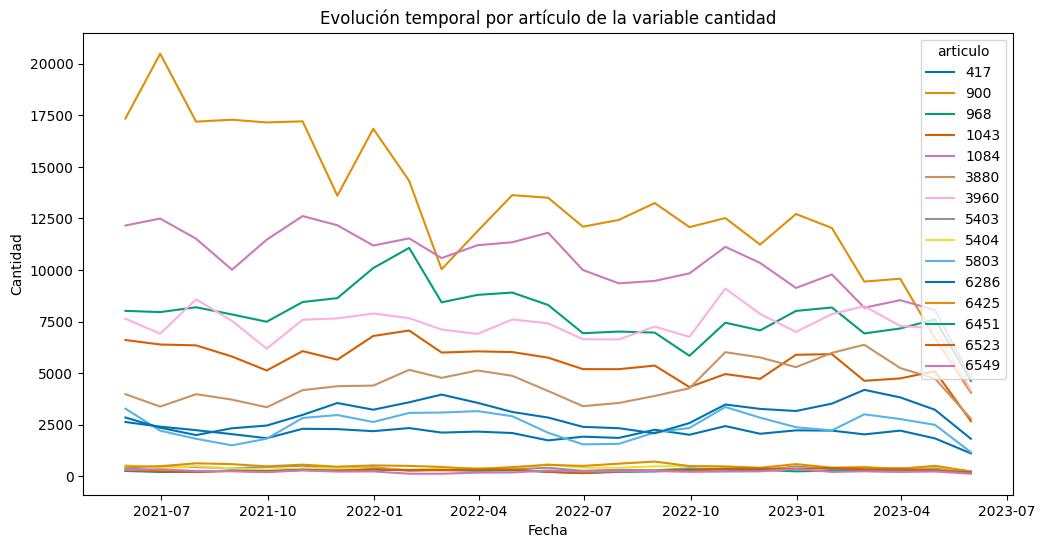

In [194]:
# Evolución temporal por artículo de la variable "cantidad"

group = df.groupby(["articulo", pd.Grouper(key="fecha_venta", freq="M")])["cantidad"].sum().reset_index()
plt.figure(figsize=(12, 6))
sns.lineplot(data=group, x='fecha_venta', y='cantidad', hue='articulo', palette='colorblind')
plt.title('Evolución temporal por artículo de la variable cantidad')
plt.xlabel('Fecha')
plt.ylabel('Cantidad')

**Grupo de preguntas 4**:

**Aplica alguna técnica estadística para observar si hay estacionalidad en la evolucion temporal general de la variable "cantidad". Pista: Tomar la primera diferencia y, después, hacer un analisis de autocorrelación.**

ADF Statistic:  -1.4110271943456132
p-value:  0.5769782744361347
Critical Values:
	1%: -3.439
	5%: -2.866
	10%: -2.569
 Non-stationary 


Text(0, 0.5, 'Cantidad')

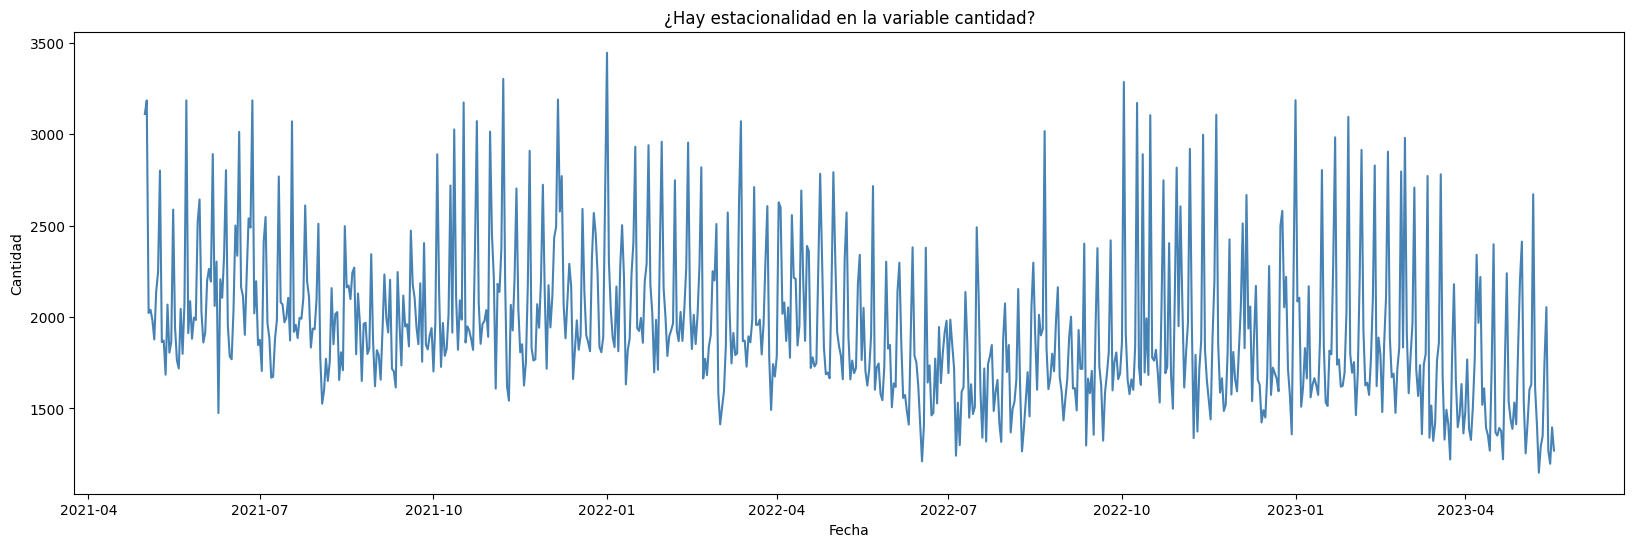

In [195]:
# Comprueba si el proceso es estacionario: prueba de Dickey-Fuller aumentada (ADF)
# La estacionariedad es una propiedad clave en el análisis de series temporales, 
# y significa que las propiedades estadísticas de la serie (como la media y la varianza) son constantes en el tiempo.

def check_stationarity(series):
    result = adfuller(series.values)

    print('ADF Statistic: ', result[0])
    print('p-value: ', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32m Stationary \u001b[0m")
    else:
        print("\x1b[31m Non-stationary \x1b[0m")

group = df.groupby([pd.Grouper(key="fecha_venta", freq="1D")])["cantidad"].sum().reset_index()
check_stationarity(group["cantidad"])
plt.figure(figsize=(20, 6))
sns.lineplot(data=group, x='fecha_venta', y='cantidad', color='steelblue')

plt.title('¿Hay estacionalidad en la variable cantidad?')
plt.xlabel('Fecha')
plt.ylabel('Cantidad')

In [196]:
# Tomando la primera diferencia

# Podemos tomar la primera diferencia para observar si nuestra serie se convierte en estacionaria.
# Esto elimina tendencias y estabiliza la varianza de la serie, permitiendo que sea modelada.

group["cantidad_diff"] = group["cantidad"].diff().fillna(0)
check_stationarity(group["cantidad_diff"])

ADF Statistic:  -12.581104640506789
p-value:  1.9096088838134613e-23
Critical Values:
	1%: -3.439
	5%: -2.866
	10%: -2.569
 Stationary 


Text(0, 0.5, 'Cantidad')

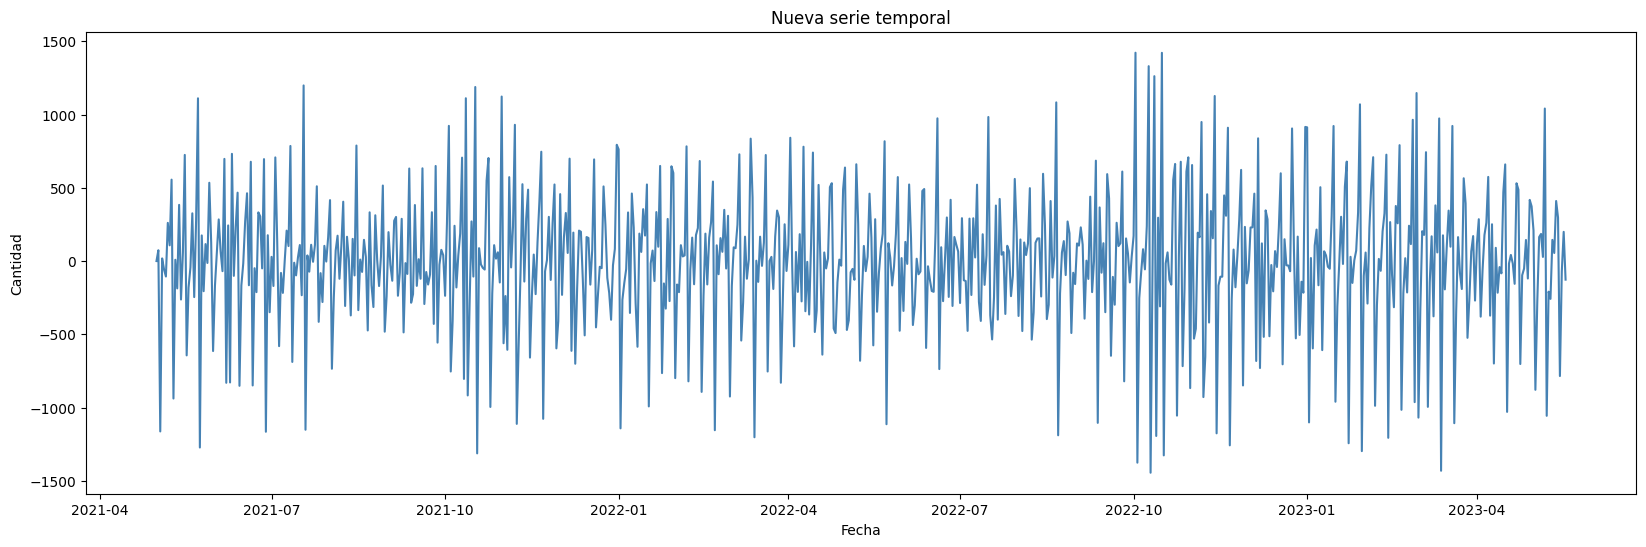

In [197]:
# La nueva serie temporal tiene esta pinta

plt.figure(figsize=(20, 6))
sns.lineplot(data=group, x='fecha_venta', y='cantidad_diff', color='steelblue')

plt.title('Nueva serie temporal')
plt.xlabel('Fecha')
plt.ylabel('Cantidad')

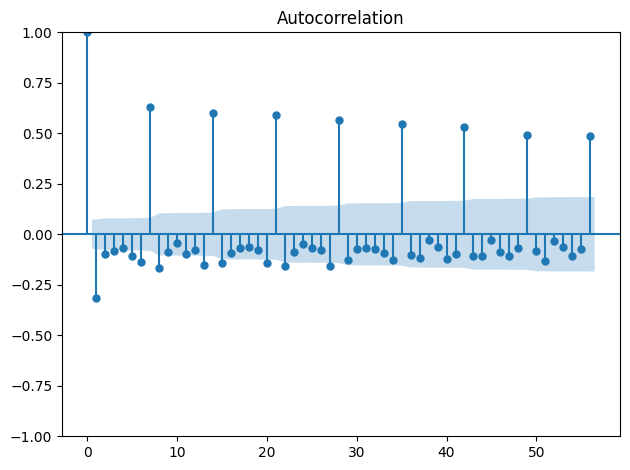

In [198]:
# Analisis de autocorrelación

# En terminos generales, este gráfico nos indica que un valor de cantidad está
# directamente relacionado con su valor de cantidad anterior y su valor de cantidad de la semana pasada.
# Parece que hay estacionalidad semanal.

plot_acf(group["cantidad_diff"],lags=56)
plt.tight_layout()
plt.show()

**Sin aplicar la primera diferencia y creando nuevas columnas de fecha a partir de la variable "fecha_venta" (semana del año, mes del año, día de la semana, día del mes, día del año) comprueba realizando diferentes agrupaciones y gráficos si nuestro análisis de autocorrelación de nuestra variable cantidad nos mostraba lo correcto. Si encuentras algún gráfico que te llame la atención, baja el nivel del análisis (Ej: 1. Cantidad general -> 2. Cantidad por familia -> 3. Cantidad por artículo).**

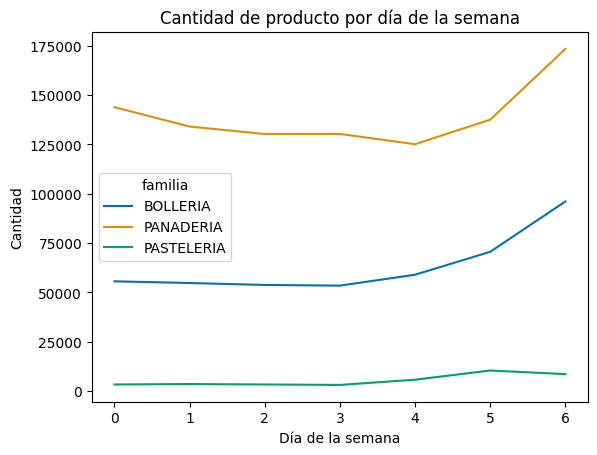

In [199]:
# Semana y mes del año
df["weekofyear"] = df["fecha_venta"].dt.isocalendar().week
df["monthofyear"] = df["fecha_venta"].dt.month

# Día de la semana, del mes y del año
df["dayofweek"] = df["fecha_venta"].dt.dayofweek #Lunes 0 y Domingo 6
df["dayofmonth"] = df["fecha_venta"].dt.day
df["dayofyear"] = df["fecha_venta"].dt.dayofyear

def graph_by_freq(freq, breakdown="familia", norm=False):
    group = df.groupby([breakdown, freq], as_index=False)["cantidad"].sum()

    if norm == True:
        group['cantidad'] = group.groupby(breakdown)['cantidad'].transform(normalize)

    sns.lineplot(data=group, x=freq, y='cantidad', hue=breakdown, markers=True, palette='colorblind')
    plt.title('Cantidad de producto por día de la semana')
    plt.xlabel('Día de la semana')
    plt.ylabel('Cantidad')
    

# A nivel familia
graph_by_freq("dayofweek")

# Como nos encontramos en nuestro análisis de autocorrelación,
# los valores de cantidad podrían tener una relación con su valor de la semana pasada
# debido a que hay un patrón de compra semanal que se repite en el tiempo.

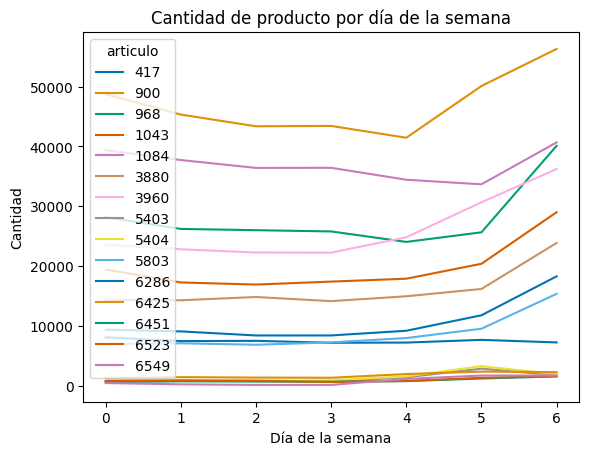

In [200]:
# A nivel articulo
graph_by_freq("dayofweek", "articulo")

Text(0, 0.5, 'Cantidad')

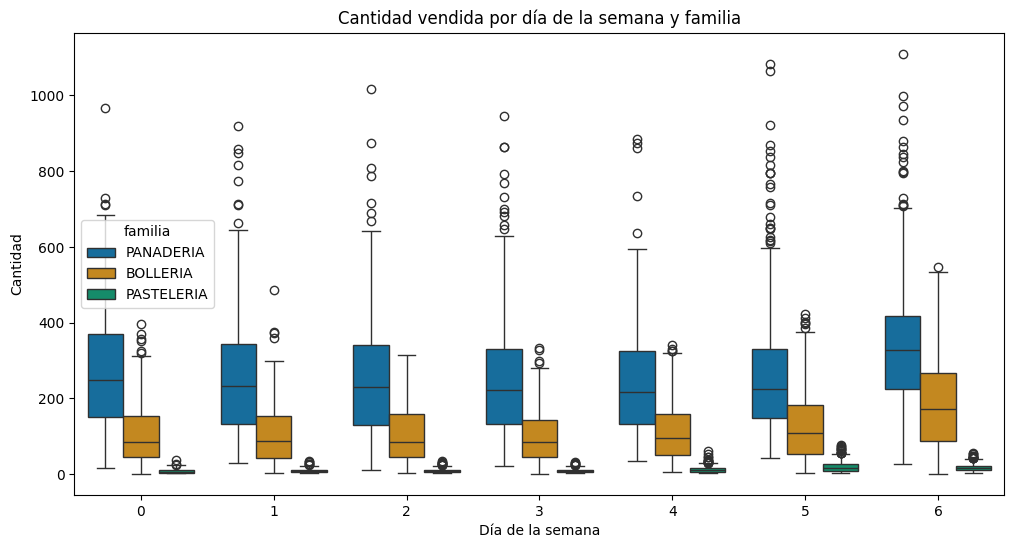

In [201]:
# Gráficos caja
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='dayofweek', y='cantidad', hue='familia', palette='colorblind')
plt.title('Cantidad vendida por día de la semana y familia')
plt.xlabel('Día de la semana')
plt.ylabel('Cantidad')

Text(0, 0.5, 'Cantidad')

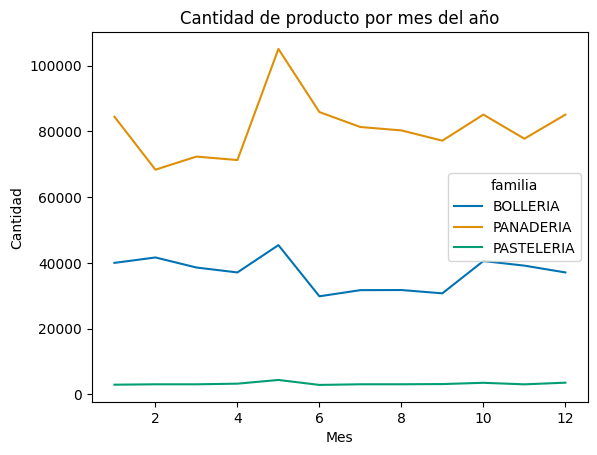

In [202]:
graph_by_freq("monthofyear")
plt.title('Cantidad de producto por mes del año')
plt.xlabel('Mes')
plt.ylabel('Cantidad')

*****

#### 4.3. Análisis de la variable a predecir frente al resto de variables

**Grupo de preguntas 5**:

**¿El comportamiento de compra (la variable "cantidad") cuando es festivo es superior a cuando no lo es?**

Text(0, 0.5, 'Cantidad')

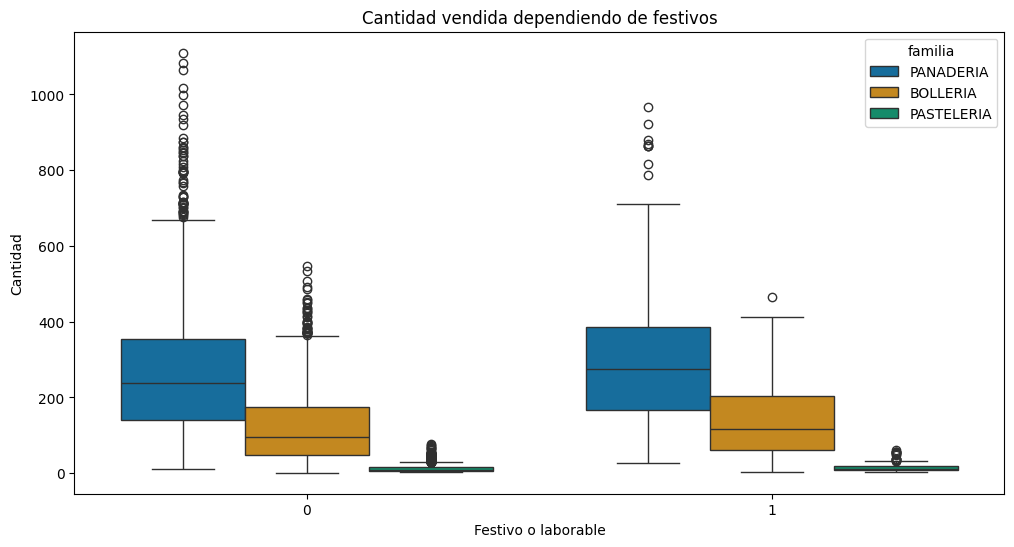

In [203]:
# 1 si es festivo, 0 si no lo es
df['es_festivo'] = df['festivo'].apply(lambda x: 0 if x is None else 1)

plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='es_festivo', y='cantidad', hue='familia', palette='colorblind')
plt.title('Cantidad vendida dependiendo de festivos')
plt.xlabel('Festivo o laborable')
plt.ylabel('Cantidad')

# El comportamiento de compra cuando es festivo parece ligeramente superior

In [224]:
df.columns

Index(['familia', 'articulo', 'fecha_venta', 'festivo', 'precio', 'cantidad',
       'importe', 'orden_articulo_familia', 'tavg_w', 'tmin_w', 'tmax_w',
       'prcp_w', 'wdir_w', 'wspd_w', 'pres_w', 'weekofyear', 'monthofyear',
       'dayofweek', 'dayofmonth', 'dayofyear', 'es_festivo', 'lluvia',
       'rango_viento', 'dir_viento', 'wdir_radianes', 'quintiles_tavg_w'],
      dtype='object')

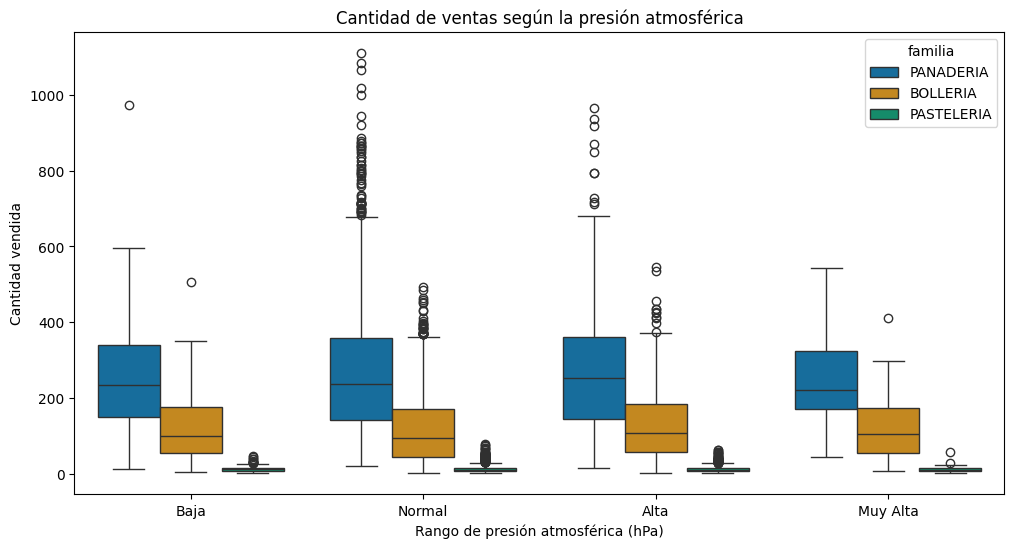

In [ ]:
# Definimos los rangos de presión
bins_presion = [1000, 1010, 1020, 1030, 1040] Rango típico de presión atmosférica
labels_presion = ["Baja", "Normal", "Alta", "Muy Alta"]

# Creamos la columna con los rangos de presión
df["rango_presion"] = pd.cut(df["pres_w"], bins=bins_presion, labels=labels_presion)

plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='rango_presion', y='cantidad', hue='familia', palette='colorblind')
plt.title("Cantidad de ventas según la presión atmosférica")
plt.xlabel("Rango de presión atmosférica (hPa)")
plt.ylabel("Cantidad vendida")

# Parece que solo afecta a la familia de panadería

In [221]:
df['pres_w'].unique()

array([1014. , 1015.9, 1017.7, 1018. , 1016.5, 1017.2, 1017.5, 1015. ,
       1011. , 1013.6, 1020.4, 1019.2, 1016.9, 1015.7, 1016.1, 1013.4,
       1015.4, 1019.8, 1018.8, 1022.7, 1017.3, 1011.8, 1020.6, 1020.3,
       1019.4, 1016.7, 1016.6, 1019. , 1017.6, 1014.6, 1011.5, 1021.1,
       1020.7, 1019.3, 1019.1, 1017.4, 1015.5, 1018.5, 1011.7, 1012.3,
       1013.2, 1014.9, 1013.8, 1012.7, 1015.3, 1018.7, 1014.4, 1016.3,
       1014.5, 1014.2, 1012.9, 1012.1, 1014.1, 1018.4, 1015.2, 1013.1,
       1016.4, 1018.1, 1012.2, 1014.3, 1016.2, 1013. , 1009. , 1009.3,
       1011.2, 1012.6, 1012. , 1013.3, 1008.2, 1014.7, 1016.8, 1018.6,
       1013.9, 1017.1, 1012.8, 1013.5, 1017.8, 1016. , 1015.6, 1017. ,
       1019.5, 1022. , 1023.2, 1013.7, 1020.9, 1020.1, 1018.3, 1018.9,
       1021.4, 1020.2, 1021.9, 1024.4, 1022.5, 1020.5, 1014.8, 1022.2,
       1021.3, 1015.8, 1017.9, 1018.2, 1011.4, 1012.4, 1010.8, 1022.9,
       1025.4, 1023.4, 1024.2, 1023.6, 1025.7, 1022.1, 1019.9, 1025.1,
      

**¿El comportamiento de compra (la variable "cantidad") cuando llueve es superior a cuando no llueve?**

Text(0, 0.5, 'Cantidad vendida')

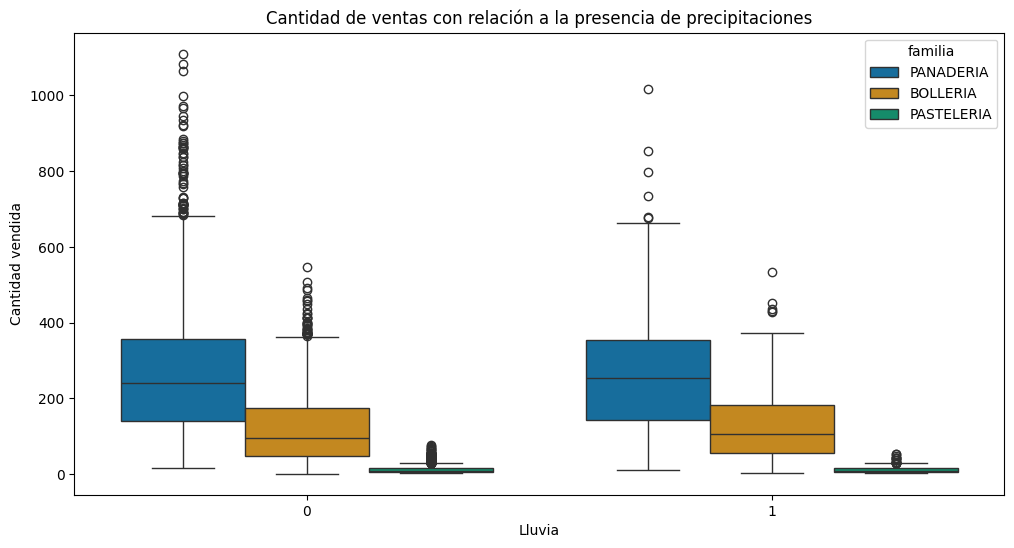

In [205]:
# 1 si llueve, 0 si no llueve
df["lluvia"] = np.where(df["prcp_w"] > 0, 1, 0)

plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='lluvia', y='cantidad', hue='familia', palette='colorblind')
plt.title('Cantidad de ventas con relación a la presencia de precipitaciones')
plt.xlabel('Lluvia')
plt.ylabel('Cantidad vendida')
# Parece que la lluvia no es un impedimiento para comprar

**¿La velocidad del viento afecta las ventas?**

Text(0, 0.5, 'Cantidad vendida')

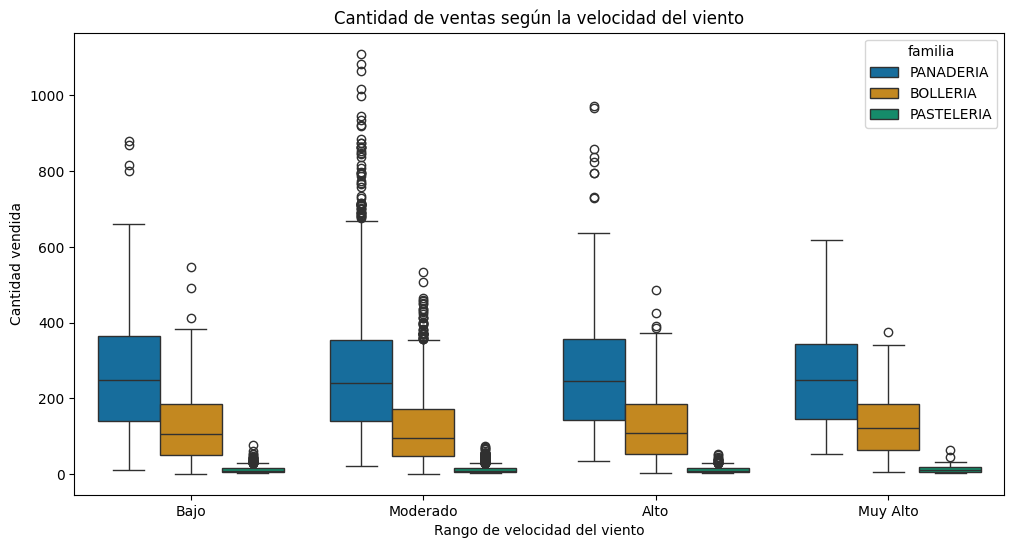

In [206]:
# Categorizamos el viento en diferentes rangos
df["rango_viento"] = pd.cut(df["wspd_w"], bins=[0, 10, 20, 30, 50], labels=["Bajo", "Moderado", "Alto", "Muy Alto"])

# Gráfico de boxplot para analizar la cantidad de ventas según el rango de viento
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='rango_viento', y='cantidad', hue='familia', palette='colorblind')
plt.title("Cantidad de ventas según la velocidad del viento")
plt.xlabel("Rango de velocidad del viento")
plt.ylabel("Cantidad vendida")

# La velocidad del viento parece no ser tan relevante de cara a la cantidad de producto vendido

**¿La dirección del viento afecta a las ventas?**

In [207]:
# Categorizamos la dirección del viento según los grados
def direccion_viento(grados):
    if (grados >= 337.5 or grados < 22.5):
        return 'N'
    elif 22.5 <= grados < 67.5:
        return 'NE'
    elif 67.5 <= grados < 112.5:
        return 'E'
    elif 112.5 <= grados < 157.5:
        return 'SE'
    elif 157.5 <= grados < 202.5:
        return 'S'
    elif 202.5 <= grados < 247.5:
        return 'SW'
    elif 247.5 <= grados < 292.5:
        return 'W'
    elif 292.5 <= grados < 337.5:
        return 'NW'

# Aplicamos la función al dataframe
df["dir_viento"] = df["wdir_w"].apply(direccion_viento)

Text(0, 0.5, 'Cantidad vendida')

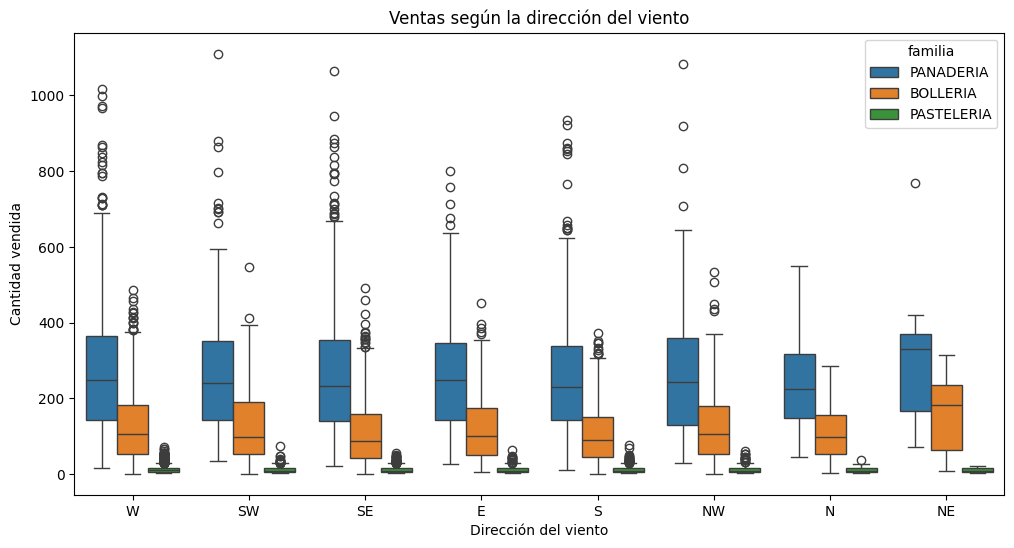

In [208]:
# Gráfico de ventas por dirección del viento
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='dir_viento', y='cantidad', hue='familia')
plt.title("Ventas según la dirección del viento")
plt.xlabel("Dirección del viento")
plt.ylabel("Cantidad vendida")

# La dirección del viento afecta un poco a la cantidad de ventas, sobre todo cuando el viento viene del norte

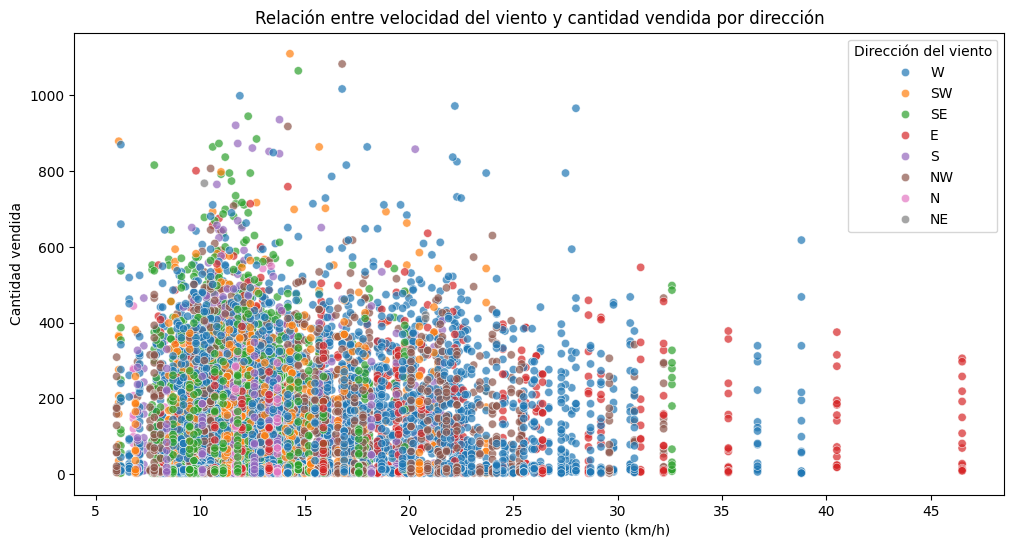

In [209]:
# Gráfico de dispersión de velocidad del viento vs cantidad, coloreado por dirección
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x="wspd_w", y="cantidad", hue="dir_viento", alpha=0.7, color='colorblind')

plt.title("Relación entre velocidad del viento y cantidad vendida por dirección")
plt.xlabel("Velocidad promedio del viento (km/h)")
plt.ylabel("Cantidad vendida")
plt.legend(title="Dirección del viento", loc="upper right")

# Las ventas tienden a ser más variables cuando la velocidad del viento es baja
# Las pocas ventas altas que hay (por encima de 600) ocurren cuando la velocidad del viento no es tan alta

**Las ventas normalmente son más cambiantes cuando la velocidad del viento es baja (por debajo de 10km/h) y cuando la velocidad del viento aumenta, parece que las ventas altas bajan (más de 500/600 unidades). Esto puede indicar que el viento muy fuerte afecta negativamente a las ventas.**

Text(0.5, 1.0, 'Promedio de ventas por dirección del viento')

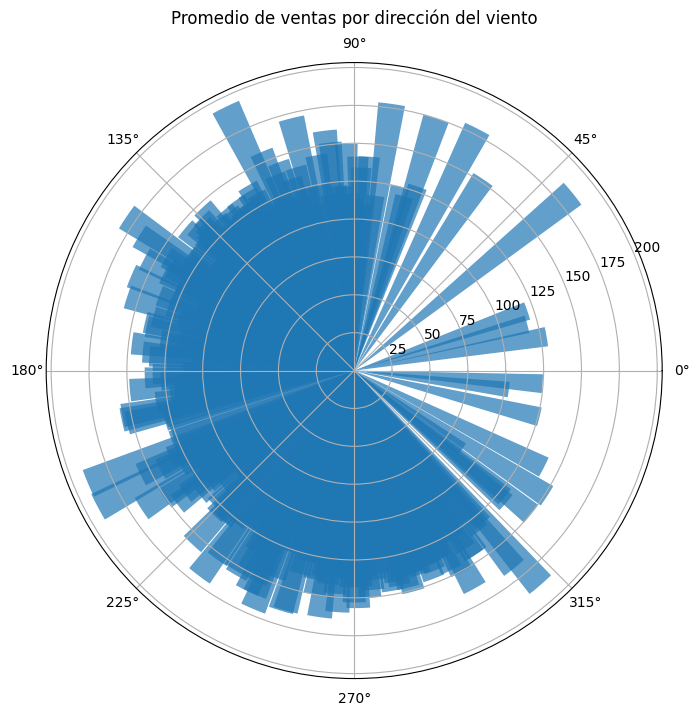

In [210]:
# Gráfico polar: relación entre dirección y ventas promedio

# Convertimos la dirección en radianes para gráfico polar
df["wdir_radianes"] = np.deg2rad(df["wdir_w"])

# Calculamos las ventas promedio por dirección
ventas_promedio = df.groupby("wdir_radianes")["cantidad"].mean()

# Creamos gráfico polar
plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)
ax.bar(ventas_promedio.index, ventas_promedio.values, width=0.1, alpha=0.7)
ax.set_title("Promedio de ventas por dirección del viento", va="bottom")


**Divide la variable "tavg_w" en quintiles y muestra con un gráfico de barras sí la variable "cantidad" es superior en alguno de sus quintiles.**

Text(0, 0.5, 'Cantidad vendida')

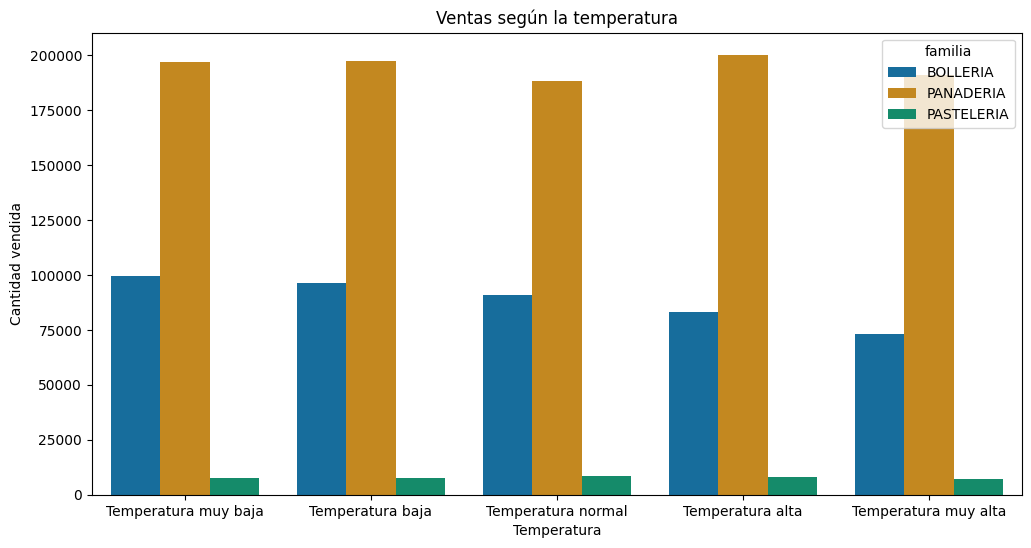

In [211]:
labels_tavg = ['Temperatura muy baja',
               'Temperatura baja',
               'Temperatura normal',
               'Temperatura alta',
               'Temperatura muy alta']

df['quintiles_tavg_w'] = pd.qcut(df['tavg_w'], q=5, labels=labels_tavg)

group = df.groupby(["familia", "quintiles_tavg_w"])["cantidad"].sum().reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(data=group, x='quintiles_tavg_w', y='cantidad', hue='familia', palette='colorblind')
#fig = px.bar(group, x='quintiles_tavg_w', y='cantidad', color="familia",barmode='group')
#fig.show()

plt.title("Ventas según la temperatura")
plt.xlabel("Temperatura")
plt.ylabel("Cantidad vendida")

**¿Cuál es la correlación entre la variable objetivo y las variables de tiempo?**

Text(0.5, 1.0, 'Correlación entre la cantidad vendida y los fenómenos meteorológicos')

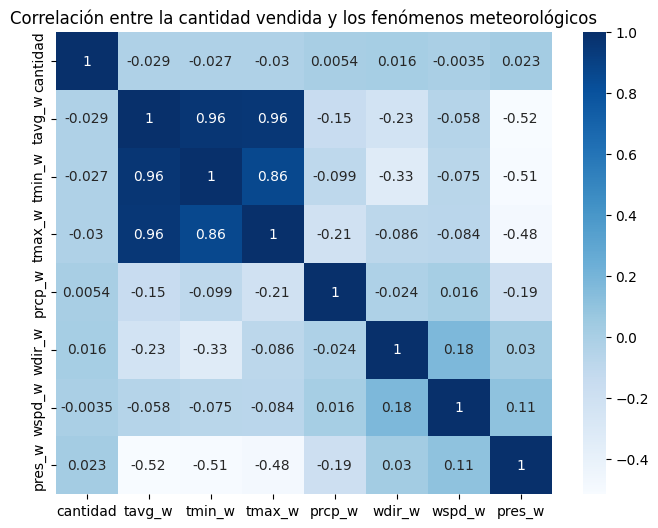

In [212]:
# Selecciono las variables que quiero usar
variables_tiempo = df[['cantidad', 'tavg_w', 'tmin_w', 'tmax_w', 'prcp_w', 'wdir_w', 'wspd_w', 'pres_w']]

plt.figure(figsize=(8, 6))
sns.heatmap(data=variables_tiempo.corr(), annot=True, cmap='Blues')
plt.title('Correlación entre la cantidad vendida y los fenómenos meteorológicos')

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'E'),
  Text(1, 0, 'N'),
  Text(2, 0, 'NE'),
  Text(3, 0, 'NW'),
  Text(4, 0, 'S'),
  Text(5, 0, 'SE'),
  Text(6, 0, 'SW'),
  Text(7, 0, 'W')])

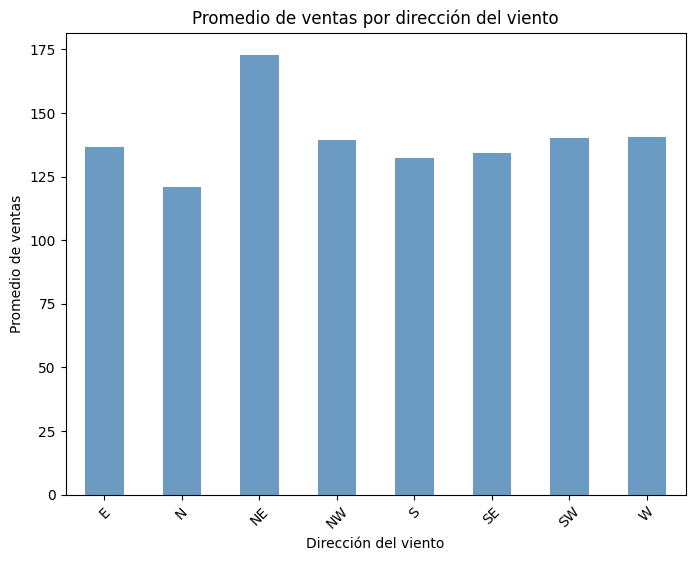

In [213]:
# Creo una variable con el promedio de ventas por dirección del viento
ventas_direccion = df.groupby("dir_viento")["cantidad"].mean()


plt.figure(figsize=(8, 6))
ventas_direccion.plot(kind="bar", color="steelblue", alpha=0.8)
plt.title("Promedio de ventas por dirección del viento")
plt.xlabel("Dirección del viento")
plt.ylabel("Promedio de ventas")
plt.xticks(rotation=45)

**Filtración por familia**

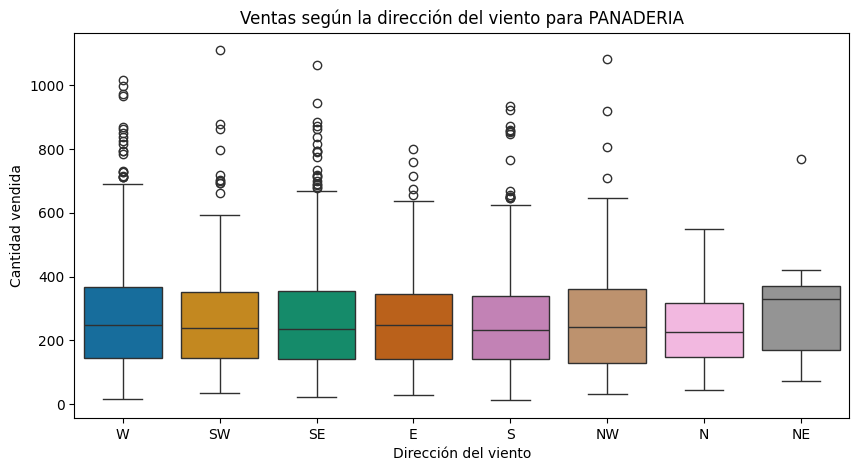

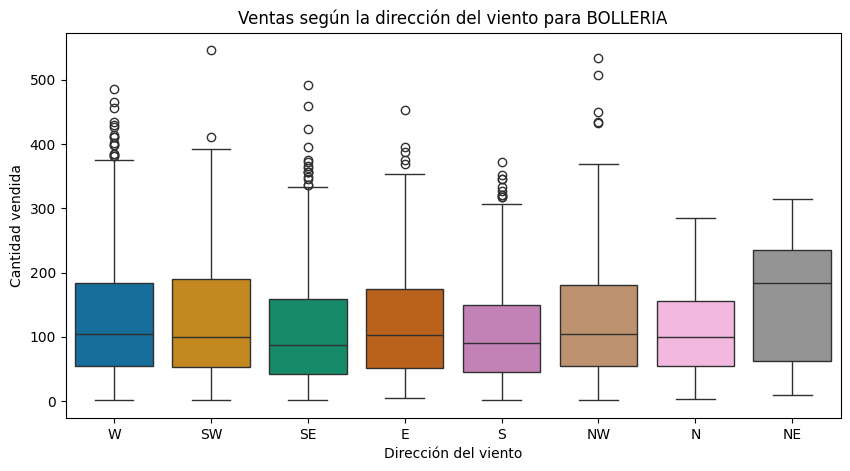

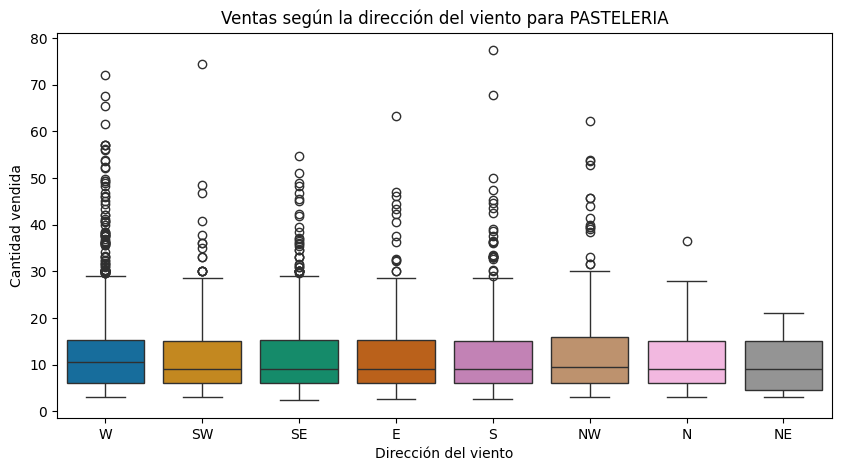

In [214]:
# Creamos una variable de familias para filtrarlo en los gráficos
familias = df["familia"].unique()

# Creamos los gráficos que muestren cómo afecta la dirección del viento a cada familia de producto vendido
for familia in familias:
    df_familia = df[df["familia"] == familia]
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=df_familia, x="dir_viento", y="cantidad", palette="colorblind", hue="dir_viento", legend=False)
    plt.title(f"Ventas según la dirección del viento para {familia}")
    plt.xlabel("Dirección del viento")
    plt.ylabel("Cantidad vendida")


**Grupo de preguntas 6**:

**¿Un incremento en el precio reduce la propensión a consumir un artículo?**

<Axes: xlabel='precio', ylabel='cantidad'>

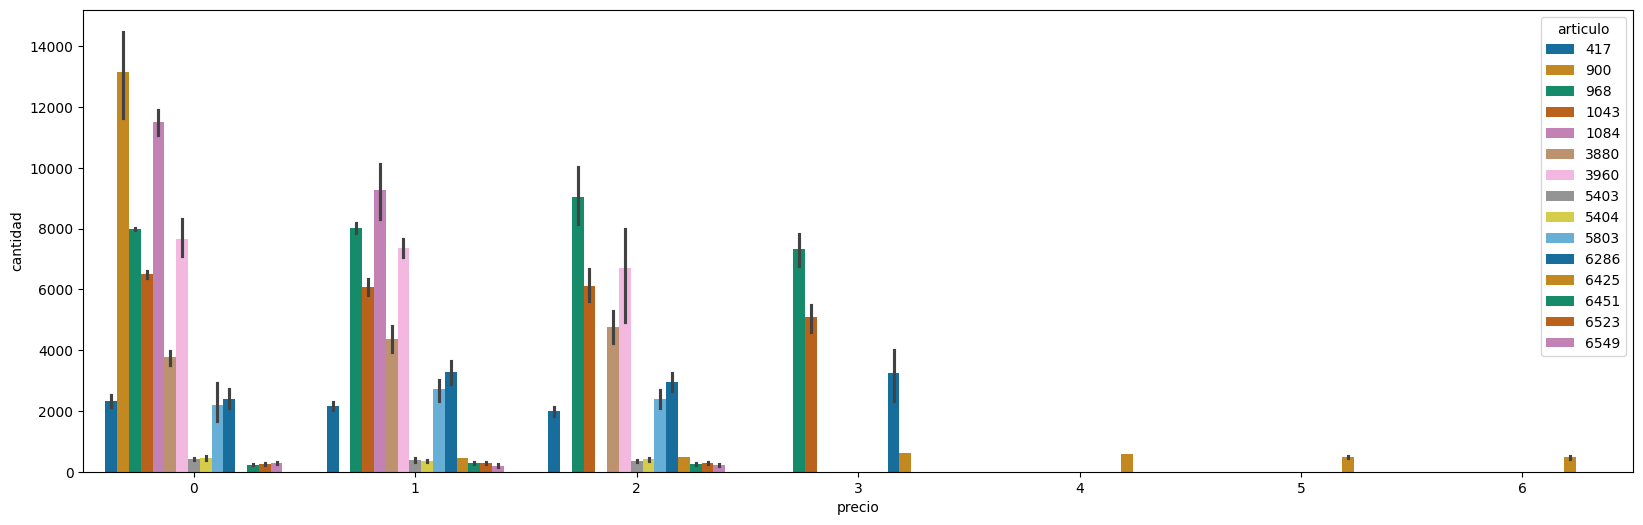

In [215]:
def function_variations(x):
    list_unique = x.unique()
    len_list = len(list_unique)

    if len_list > 1:
        return 1
    else:
        return 0

group = df.groupby(["articulo",
                    pd.Grouper(key="fecha_venta", freq="1M"),
                    "familia"]).agg({"cantidad": "sum",
                                     "precio": function_variations}).reset_index()

group["precio"] = group.groupby("articulo")["precio"].transform("cumsum")
group["precio"] = group["precio"].astype(object)

plt.figure(figsize=(20, 6))
sns.barplot(data=group, x='precio', y='cantidad', hue='articulo', palette="colorblind")
#fig = px.box(group, x="precio", y="cantidad", color='articulo')
#
# fig.show()

# No es concluyente debido a que puede haber una tendencia negativa/positiva en el consumo general del articulo
# a lo largo del tiempo, pero es interesante observar como muchas veces si que tiene un impacto negativo
# (productos: 417, 1043, 1084, 3960, 5403).
# Podría ser también por la canibalización de nuevos productos a otros anteriores.

*****

**Sobre ventas generales**

**1. ¿Qué artículos y familias generan más ventas?**

articulo
900     328641.000000
1084    258702.198002
968     195974.690998
3960    182637.000000
1043    138355.344000
3880    112668.000000
6286     74630.928000
5803     61154.790000
417      52491.000000
6425     12178.560010
Name: cantidad, dtype: float64


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, '900'),
  Text(1, 0, '1084'),
  Text(2, 0, '968'),
  Text(3, 0, '3960'),
  Text(4, 0, '1043'),
  Text(5, 0, '3880'),
  Text(6, 0, '6286'),
  Text(7, 0, '5803'),
  Text(8, 0, '417'),
  Text(9, 0, '6425')])

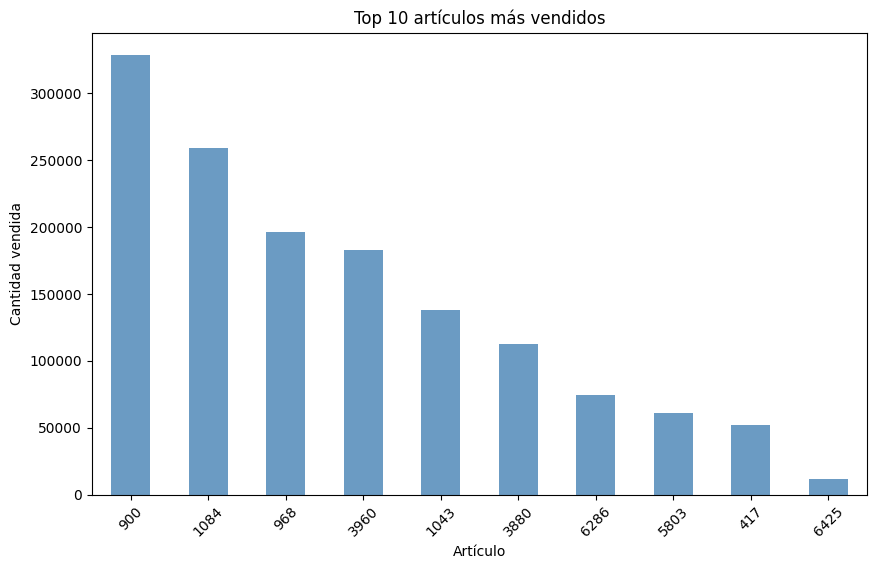

In [216]:
# Agrupo el total de ventas por artículo ordenado de mayor a menor
ventas_por_articulo = df.groupby("articulo")["cantidad"].sum().sort_values(ascending=False)

# Muestro los 10 artículos más vendidos
print(ventas_por_articulo.head(10))

ventas_por_articulo.head(10).plot(kind="bar", figsize=(10, 6), color="steelblue", alpha=0.8)
plt.title("Top 10 artículos más vendidos")
plt.xlabel("Artículo")
plt.ylabel("Cantidad vendida")
plt.xticks(rotation=45)

familia
PANADERIA     974164.233000
BOLLERIA      443269.278011
PASTELERIA     38478.906024
Name: cantidad, dtype: float64


(array([0, 1, 2]),
 [Text(0, 0, 'PANADERIA'), Text(1, 0, 'BOLLERIA'), Text(2, 0, 'PASTELERIA')])

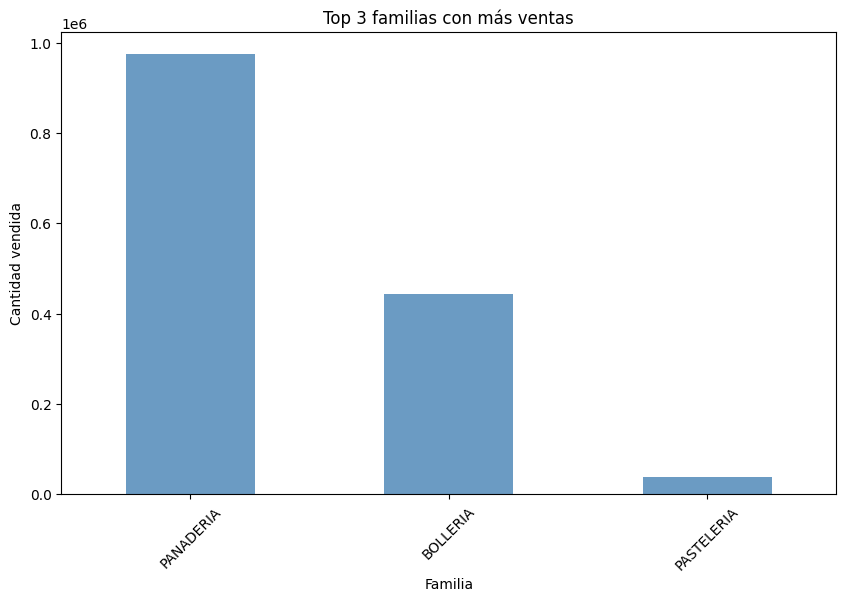

In [217]:
ventas_por_familia = df.groupby("familia")["cantidad"].sum().sort_values(ascending=False)

# Muestro el total de familias que tienen más ventas
print(ventas_por_familia.head(10))

ventas_por_familia.head(10).plot(kind="bar", figsize=(10, 6), color="steelblue", alpha=0.8)
plt.title("Top 3 familias con más ventas")
plt.xlabel("Familia")
plt.ylabel("Cantidad vendida")
plt.xticks(rotation=45)

**2. ¿Cualés son los 5 productos top de cada familia?**

In [218]:
# Variable para encontrar los 5 artículos que más se venden por familia
top_articles = (
    df.groupby(["familia", "articulo"])["importe"]  # Agrupamos por familia y artículo
    .sum()  # Sumamos el importe total por artículo
    .reset_index()  # Reseteamos el índice para trabajar con un DataFrame
    .sort_values(["familia", "importe"], ascending=[True, False])  # Ordenamos por familia y luego por importe
    .groupby("familia")  # Agrupamos por familia nuevamente
    .head(5)  # Seleccionamos los primeros 5 productos de cada familia
)

print(top_articles)

       familia  articulo        importe
1     BOLLERIA      3960  481936.486245
4     BOLLERIA      6425  404490.611078
0     BOLLERIA      3880  358782.327599
3     BOLLERIA      6286  277846.845303
2     BOLLERIA      5803  199854.300753
7    PANADERIA       968  466167.473733
8    PANADERIA      1043  399519.331871
6    PANADERIA       900  313712.550203
9    PANADERIA      1084  265923.216182
5    PANADERIA       417  234517.002527
11  PASTELERIA      5404  421626.843613
10  PASTELERIA      5403  350073.058075
13  PASTELERIA      6523  270038.150917
12  PASTELERIA      6451  269446.188332
14  PASTELERIA      6549  176760.487358


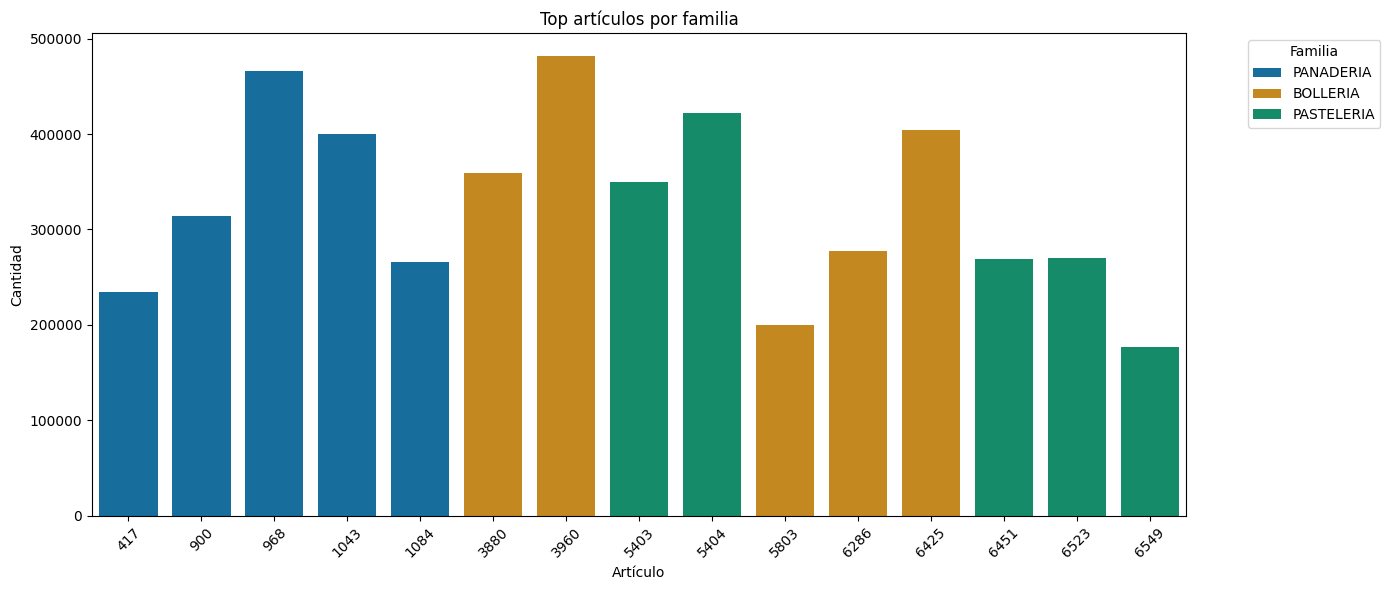

In [219]:
# Gráfico para visualizar la el "top_articles"
plt.figure(figsize=(14, 6))
sns.barplot(data=top_articles, x="articulo", y="importe", hue="familia", dodge=False, # Evitamos separar las barras por familia
    palette="colorblind"
)

plt.title("Top artículos por familia")
plt.xlabel("Artículo")
plt.ylabel("Cantidad")
plt.legend(title="Familia", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xticks(rotation=45)
plt.tight_layout()

/tmp/ipykernel_5764/3491285425.py:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




Text(0, 0.5, 'Ventas promedio')

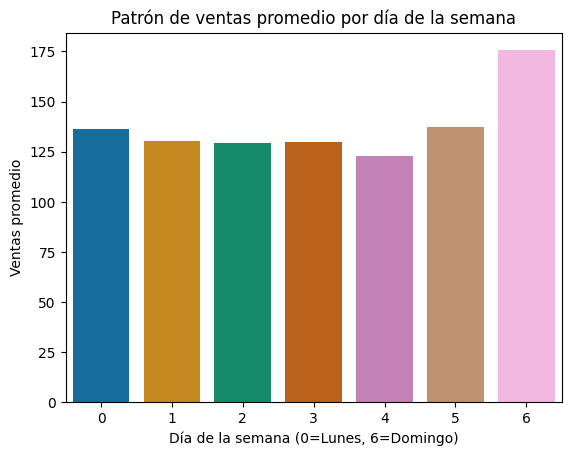

In [220]:
# Resumen de ventas por día de la semana
df["dayofweek"] = df["fecha_venta"].dt.dayofweek
weekly_pattern = df.groupby("dayofweek")["cantidad"].mean()

# Gráfico
sns.barplot(x=weekly_pattern.index, y=weekly_pattern.values, palette='colorblind')
plt.title("Patrón de ventas promedio por día de la semana")
plt.xlabel("Día de la semana (0=Lunes, 6=Domingo)")
plt.ylabel("Ventas promedio")